# Poisson HMM on example session

In [7]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import PoissonHMM


# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files, prepro_design_matrix, concatenate_sessions, fix_discontinuities
from fitting_functions import cross_validate_poismodel
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from plotting_functions import plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates, traces_over_few_sates
from postprocessing_functions import best__kappa
one = ONE(mode='remote')

## Parameters

In [8]:
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
            ['left_X', 'left_Y', 'right_X', 'right_Y'], ['nose_X', 'nose_Y']]
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
            ['left_X', 'left_Y', 'right_X', 'right_Y']]
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me']]
var_interest_map = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'left_X', 'nose_X']
idx_init_list = [0, 1, 2, 3, 7]
idx_end_list = [1, 2, 3, 7, 9]

In [9]:
num_iters = 100
method = 'kmeans'
sticky = False
bin_size = 0.1
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

num_train_batches = 5
threshold = 0.01

num_states = 2
kappa = 3

# use_vars = ['avg_wheel_vel', 'Lick count', 'whisker_me',
#        'left_X', 'left_Y', 'right_X', 'right_Y', 'nose_X', 'nose_Y']
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
            ['left_X', 'left_Y', 'right_X', 'right_Y'], ['nose_X', 'nose_Y']]
var_interest_map = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'left_X', 'nose_X']
idx_init_list = [0, 1, 2, 3, 7]
idx_end_list = [1, 2, 3, 7, 9]

var_interest = 'Lick count'

# Values for grid search (should get this from results)
last_lag = 20
lag_step = 2
start_lag = 1
Lags = list(range(start_lag, last_lag, lag_step))
if sticky:
    kappas = [1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]
else:
    kappas = [0, 1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]

## Get data

In [10]:
# Load preprocessed data
prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/90_trials/' + str(bin_size) + '/'
os.chdir(prepro_results_path)
idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(prepro_results_path + "preprocessed_data_v4_170724", "rb"))
collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)

In [5]:
# num_iters = 100
# num_train_batches = 5
# method = 'kmeans'
# threshold = 0.05

# num_lags = 5  # First order ARHMM
# num_states = 2
# kappa = 100

# # use_vars = ['avg_wheel_vel', 'Lick count', 'whisker_me',
# #        'left_X', 'left_Y', 'right_X', 'right_Y', 'nose_X', 'nose_Y']
# use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
#             ['left_X', 'left_Y', 'right_X', 'right_Y'], ['nose_X', 'nose_Y']]
# var_interest_map = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'left_X', 'nose_X']
# idx_init_list = [0, 1, 2, 3, 7]
# idx_end_list = [1, 2, 3, 7, 9]

# var_interest = 'Lick count'

# sticky = False
# # Values for grid search (should get this from results)
# last_lag = 20
# lag_step = 2
# start_lag = 1
# Lags = list(range(start_lag, last_lag, lag_step))
# if sticky:
#     kappas = [1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]
# else:
#     kappas = [0, 1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]

7416f387-b302-4ca3-8daf-03b585a1b7ec_SWC_052


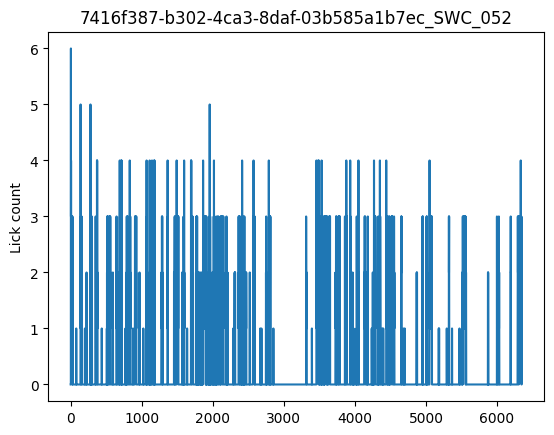

72cb5550-43b4-4ef0-add5-e4adfdfb5e02_ZFM-02369


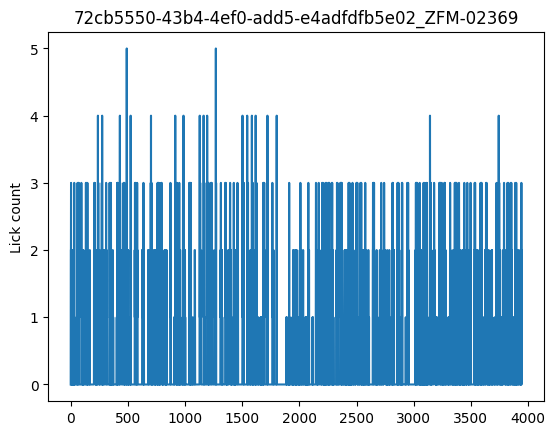

360eac0c-7d2d-4cc1-9dcf-79fc7afc56e7_SWC_061


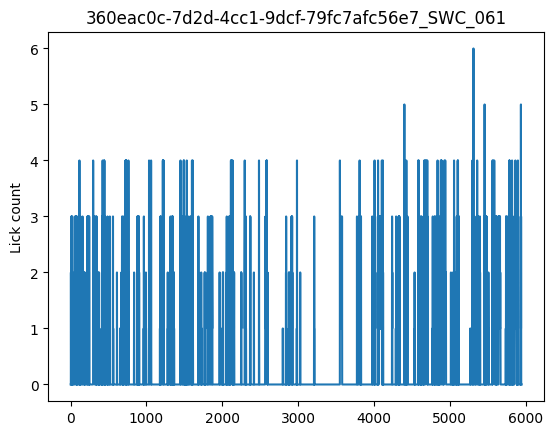

d839491f-55d8-4cbe-a298-7839208ba12b_CSHL049


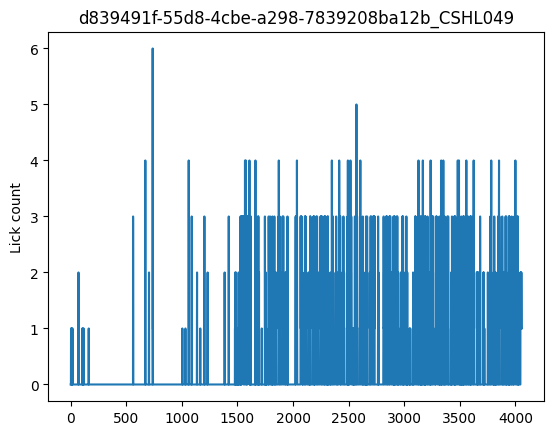

032452e9-1886-449d-9c13-0f192572e19f_SWC_053


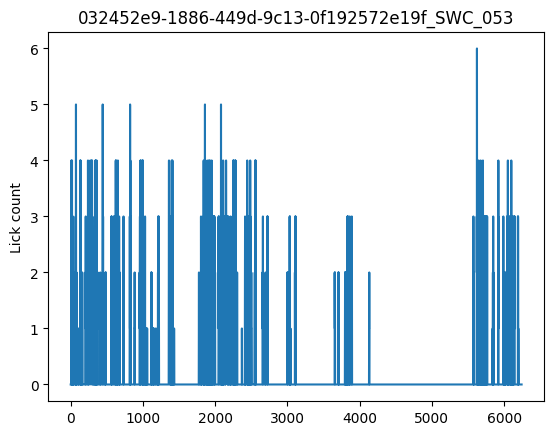

28741f91-c837-4147-939e-918d38d849f2_CSHL058


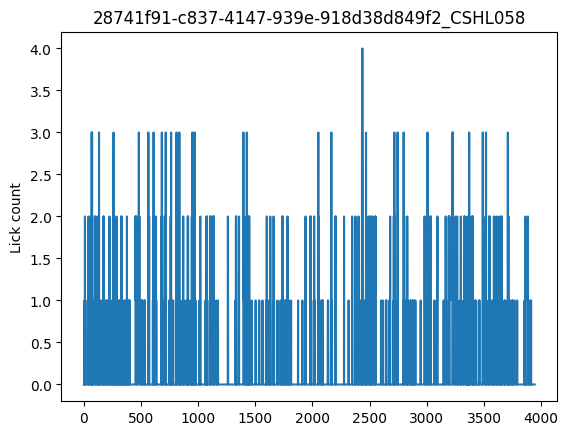

2c44a360-5a56-4971-8009-f469fb59de98_ZFM-01936


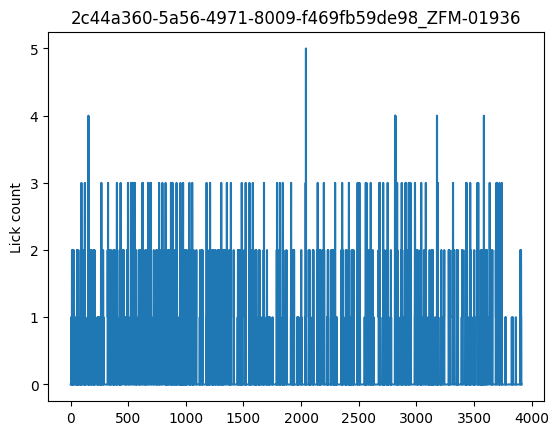

c6db3304-c906-400c-aa0f-45dd3945b2ea_SWC_043


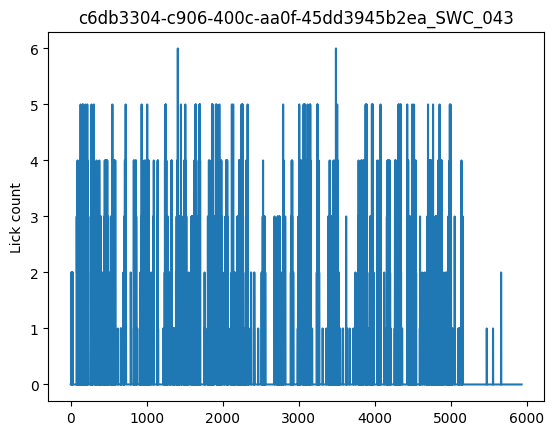

aad23144-0e52-4eac-80c5-c4ee2decb198_KS023


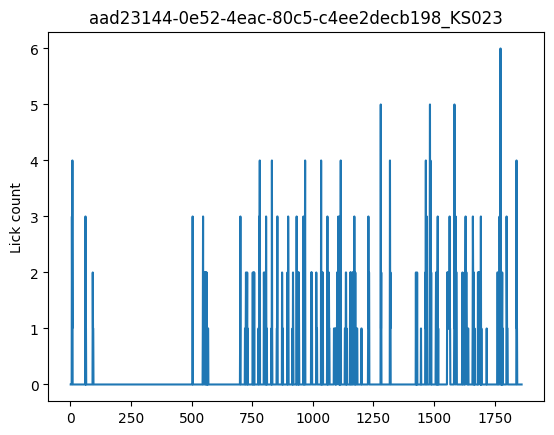

75b6b132-d998-4fba-8482-961418ac957d_SWC_053


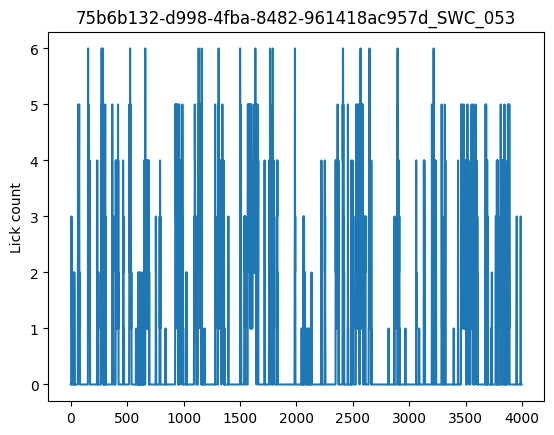

d33baf74-263c-4b37-a0d0-b79dcb80a764_ZM_2240


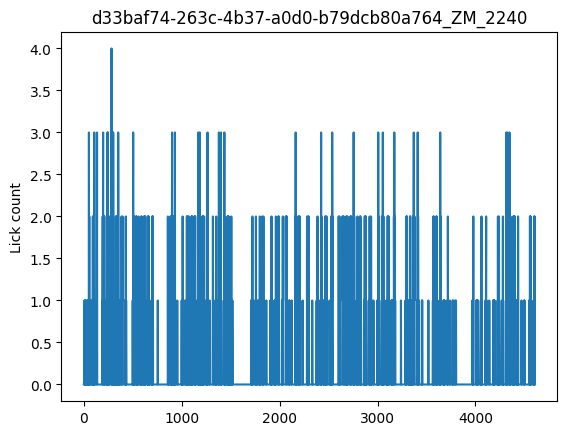

54238fd6-d2d0-4408-b1a9-d19d24fd29ce_DY_018


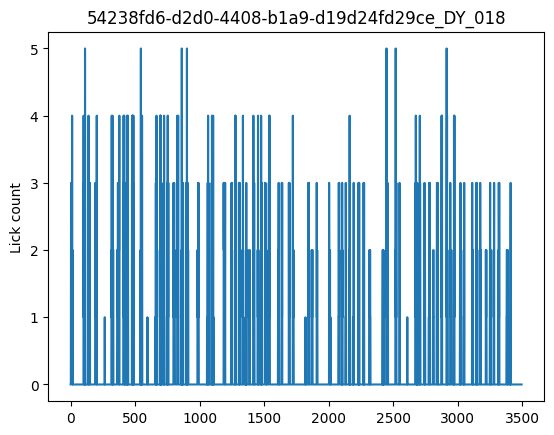

fb70ebf7-8175-42b0-9b7a-7c6e8612226e_CSHL058


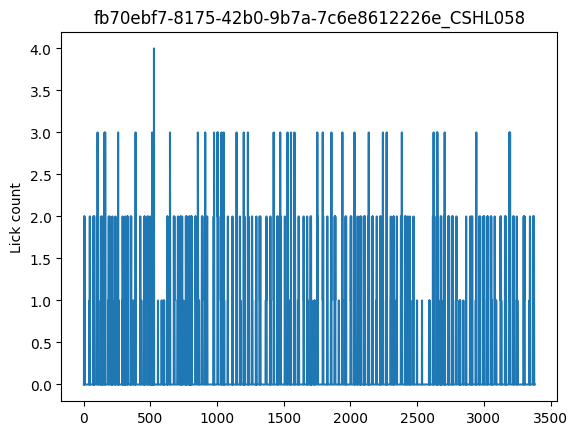

510b1a50-825d-44ce-86f6-9678f5396e02_ZM_2240


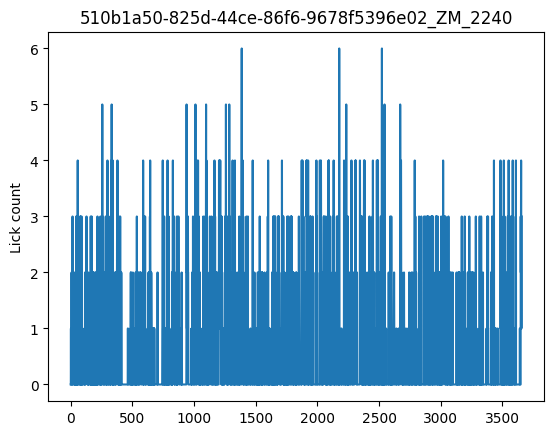

746d1902-fa59-4cab-b0aa-013be36060d5_ZFM-01592


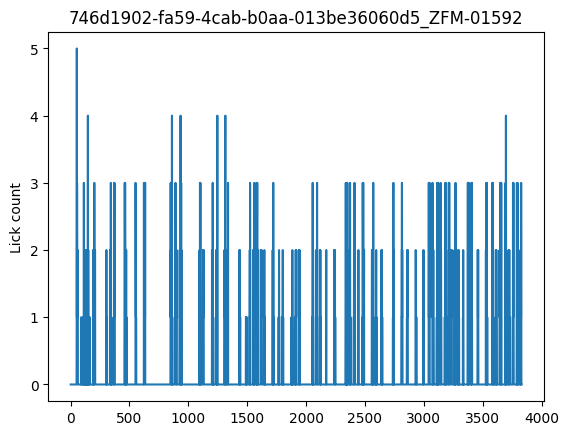

46794e05-3f6a-4d35-afb3-9165091a5a74_CSHL045


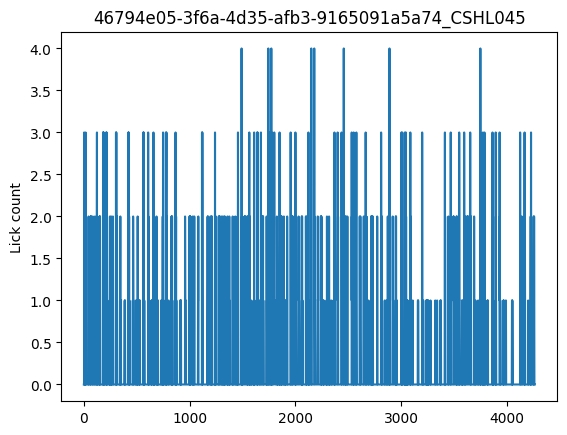

934dd7a4-fbdc-459c-8830-04fe9033bc28_ZM_3003


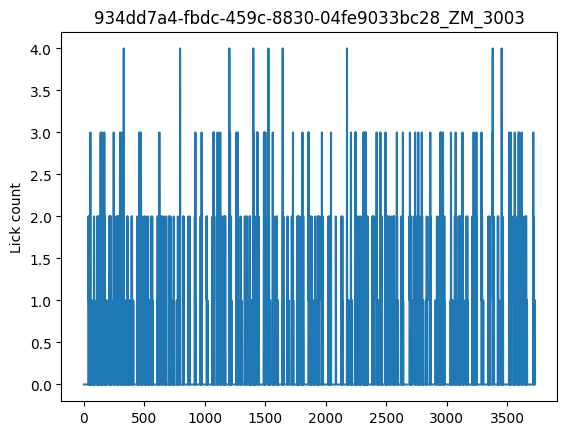

71e03be6-b497-4991-a121-9416dcc1a6e7_ZFM-01935


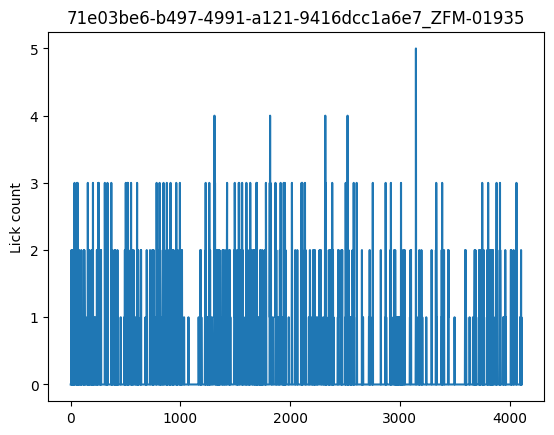

5339812f-8b91-40ba-9d8f-a559563cc46b_DY_016


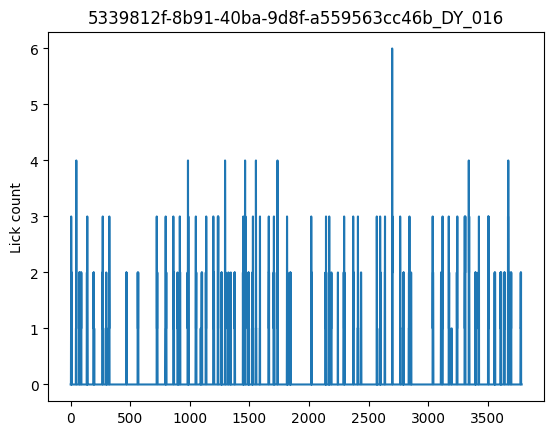

45ef6691-7b80-4a43-bd1a-85fc00851ae8_SWC_052


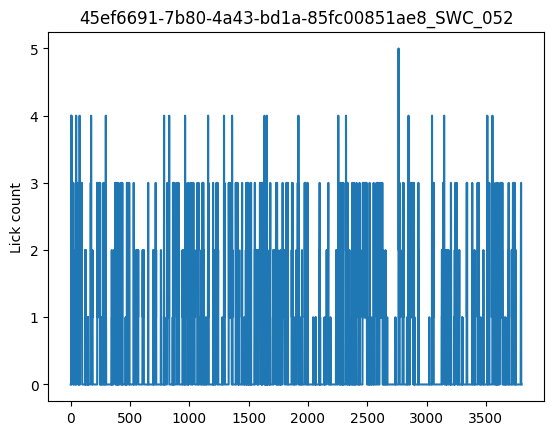

6bb5da8f-6858-4fdd-96d9-c34b3b841593_SWC_054


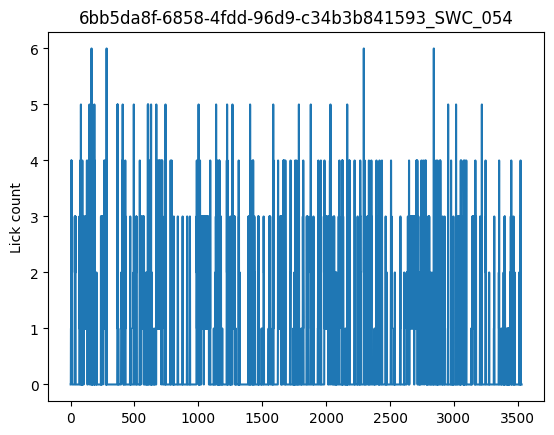

bda2faf5-9563-4940-a80f-ce444259e47b_UCLA037


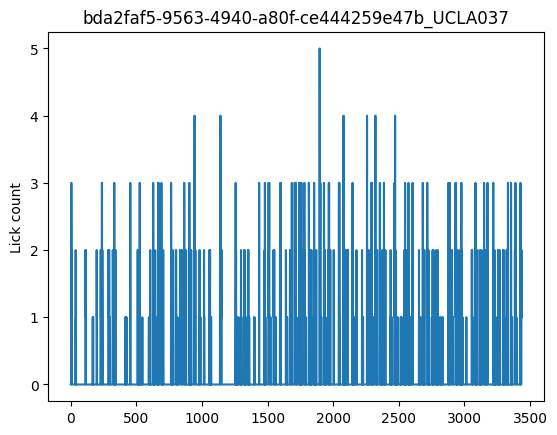

7939711b-8b4d-4251-b698-b97c1eaa846e_CSHL045


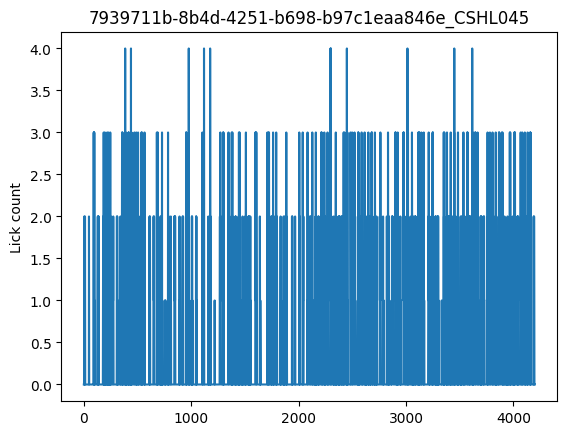

86b6ba67-c1db-4333-add0-f8105ea6e363_ibl_witten_29


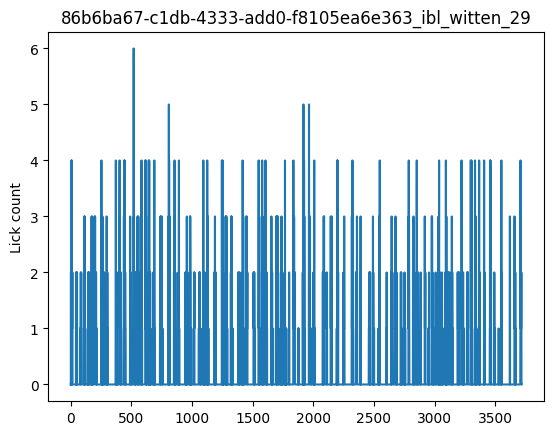

d901aff5-2250-467a-b4a1-0cb9729df9e2_NR_0020


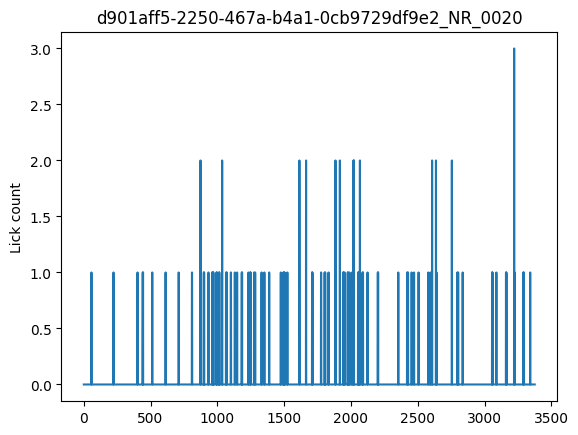

53738f95-bd08-4d9d-9133-483fdb19e8da_ZM_1898


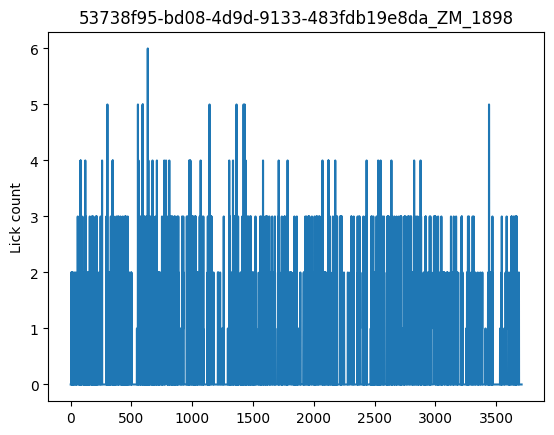

3f6e25ae-c007-4dc3-aa77-450fd5705046_ZFM-01936


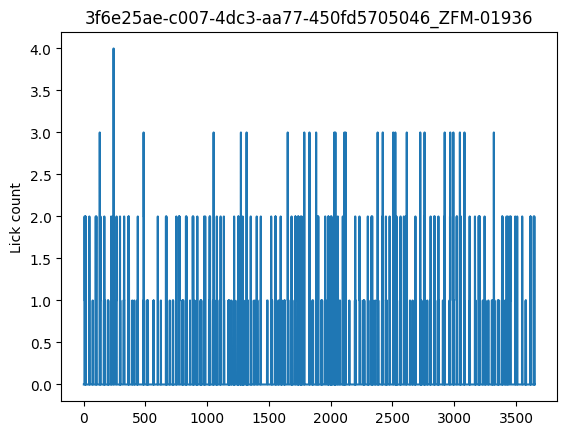

1b715600-0cbc-442c-bd00-5b0ac2865de1_KS084


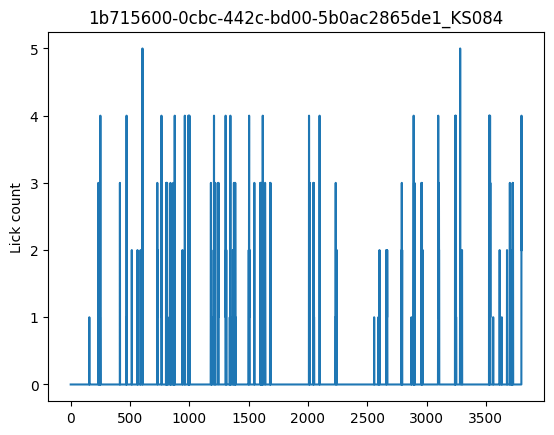

78b4fff5-c5ec-44d9-b5f9-d59493063f00_KS091


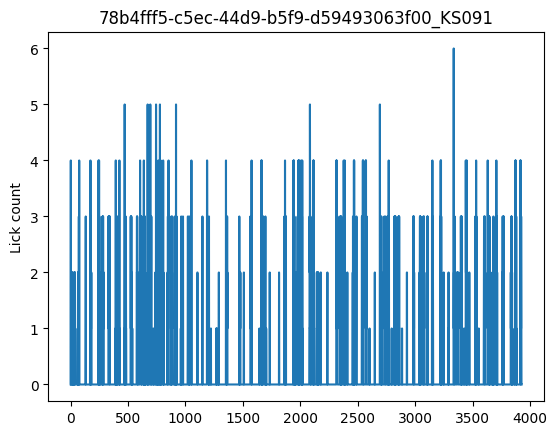

15f742e1-1043-45c9-9504-f1e8a53c1744_KS022


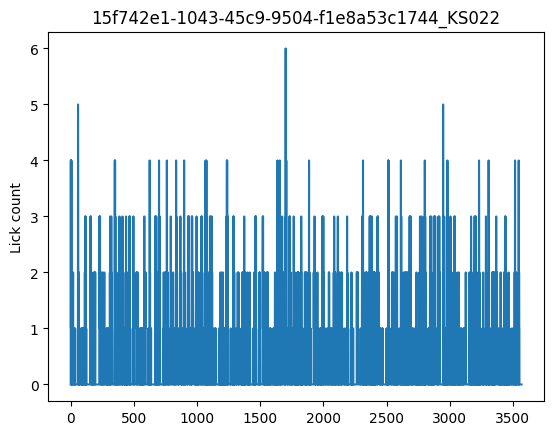

111c1762-7908-47e0-9f40-2f2ee55b6505_UCLA033


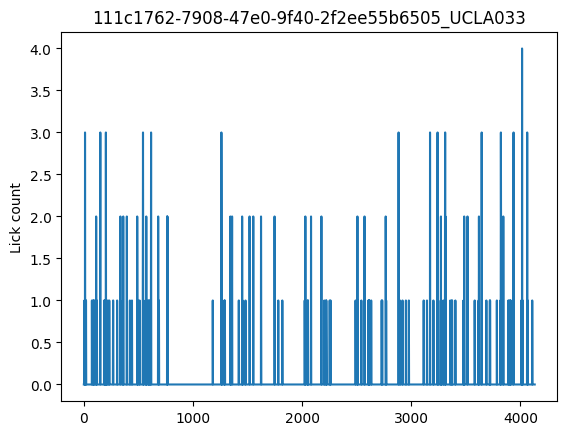

c3d9b6fb-7fa9-4413-a364-92a54df0fc5d_DY_016


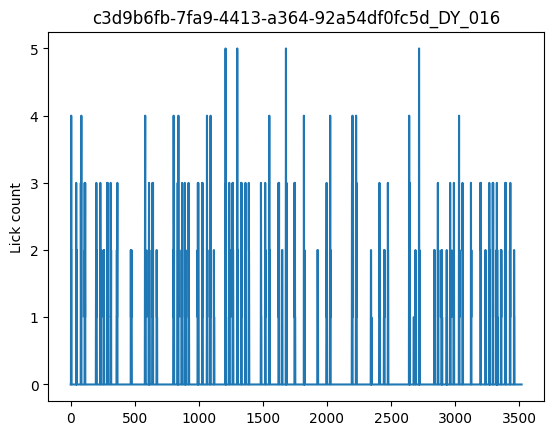

37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0_CSHL059


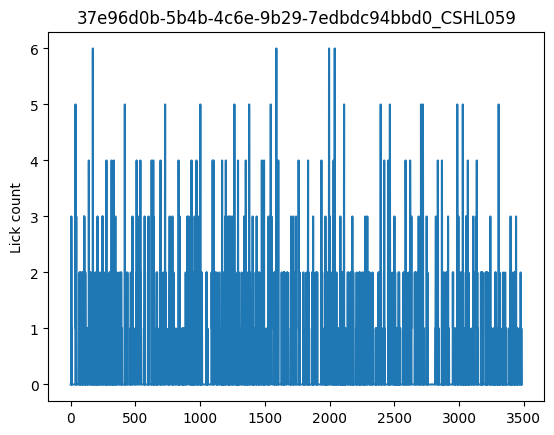

88224abb-5746-431f-9c17-17d7ef806e6a_ZFM-02372


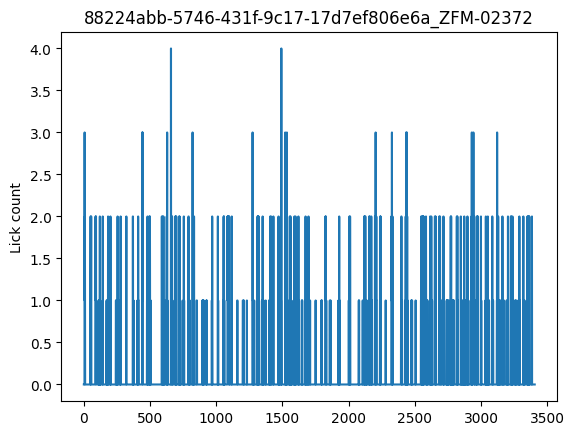

8b1f4024-3d96-4ee7-95f9-8a1dfd4ce4ef_PL017


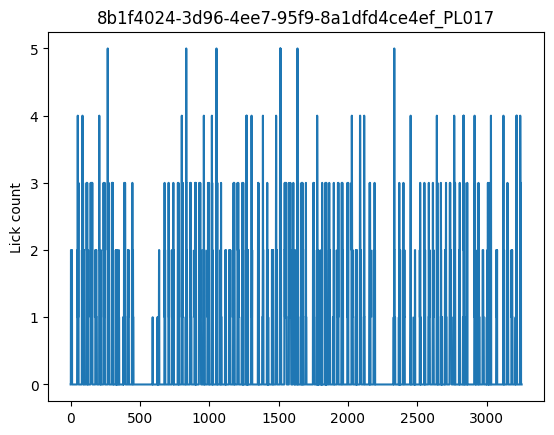

fa704052-147e-46f6-b190-a65b837e605e_CSHL045


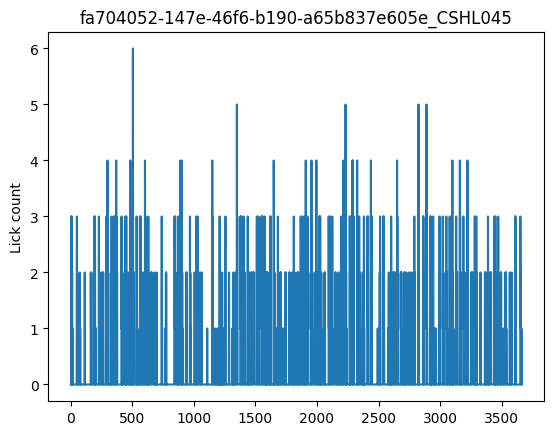

4aa1d525-5c7d-4c50-a147-ec53a9014812_ZFM-01936


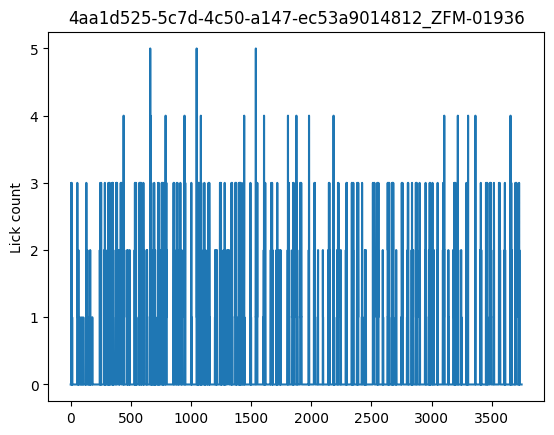

58b1e920-cfc8-467e-b28b-7654a55d0977_ibl_witten_29


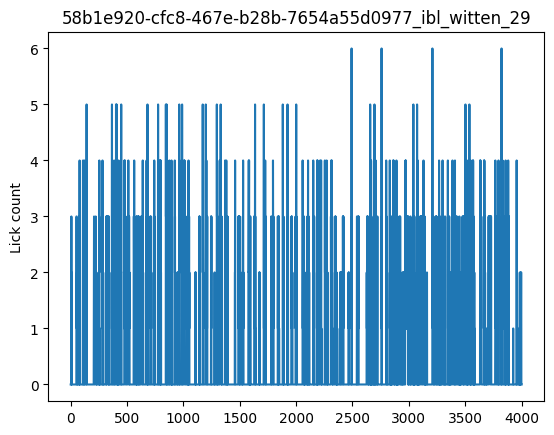

1f095590-6669-46c9-986b-ccaf0620c5e9_UCLA012


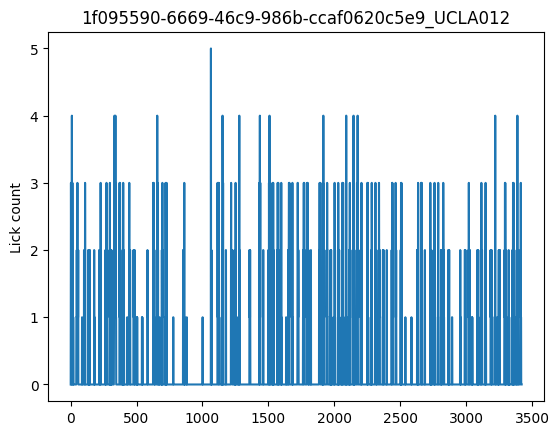

a71175be-d1fd-47a3-aa93-b830ea3634a1_CSHL054


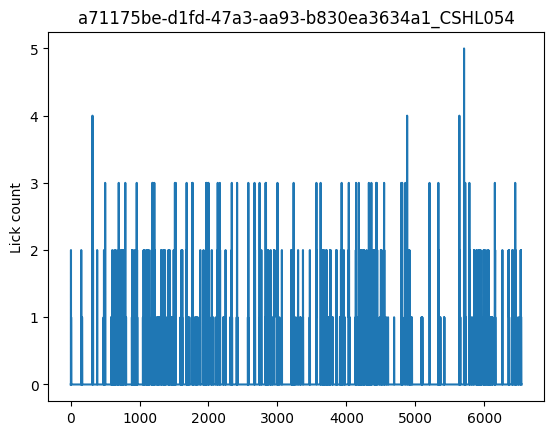

fe1fd79f-b051-411f-a0a9-2530a02cc78d_ZM_3003


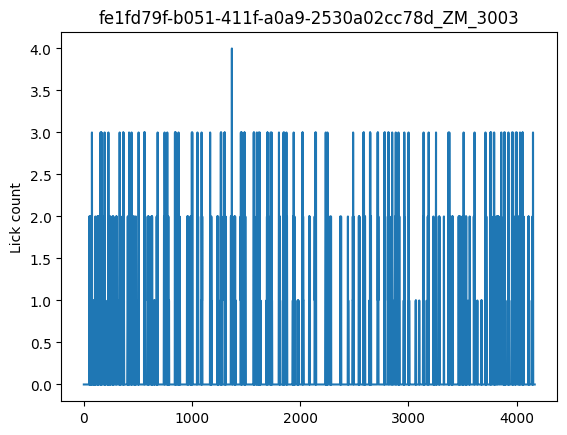

ecb5520d-1358-434c-95ec-93687ecd1396_CSHL051


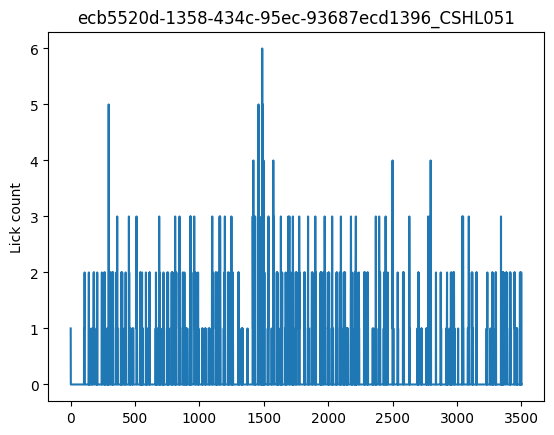

9b5a1754-ac99-4d53-97d3-35c2f6638507_ZFM-01936


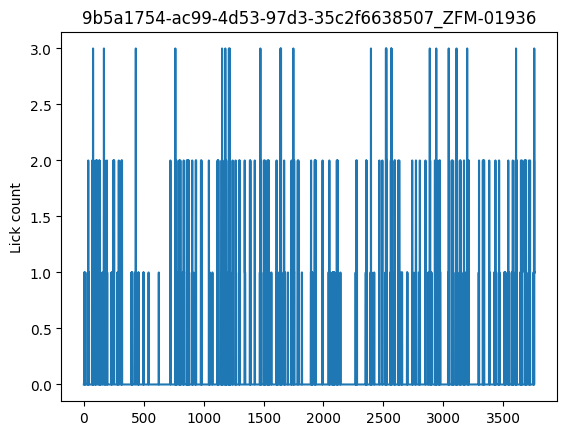

e535fb62-e245-4a48-b119-88ce62a6fe67_DY_013


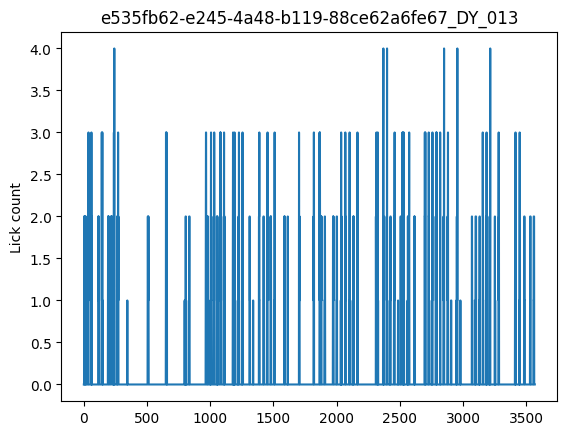

7be8fec4-406b-4e74-8548-d2885dcc3d5e_CSHL060


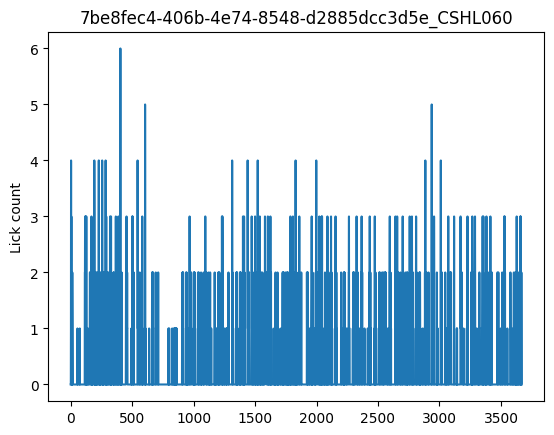

a4000c2f-fa75-4b3e-8f06-a7cf599b87ad_KS023


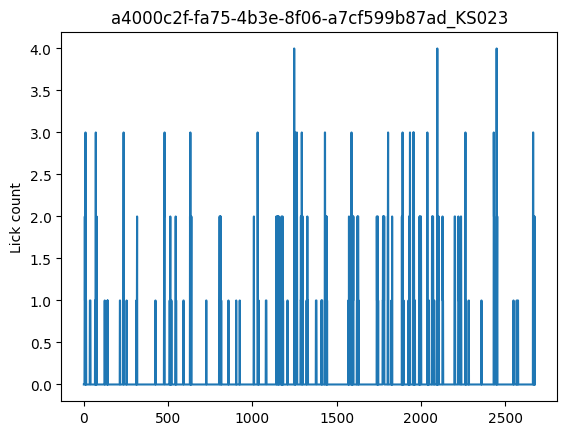

ab8a0899-a59f-42e4-8807-95b14056104b_ZFM-01935


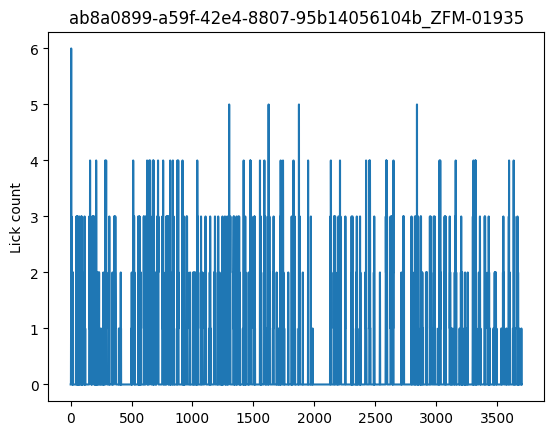

03063955-2523-47bd-ae57-f7489dd40f15_SWC_038


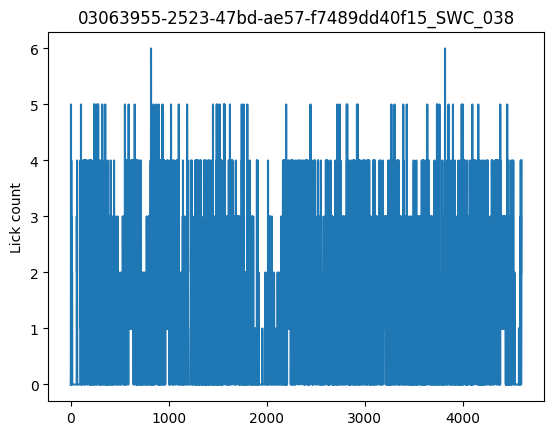

f27e6cd6-cdd3-4524-b8e3-8146046e2a7d_PL017


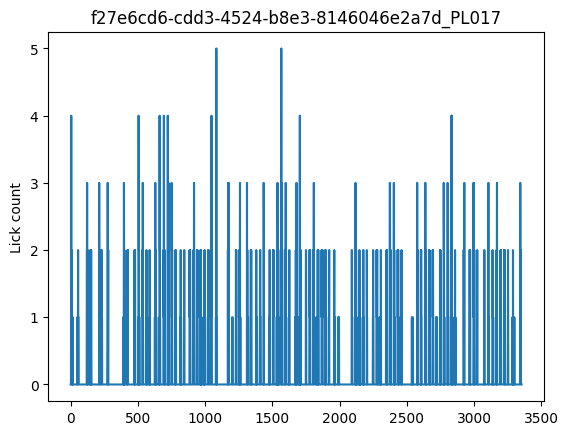

9a6e127b-bb07-4be2-92e2-53dd858c2762_PL015


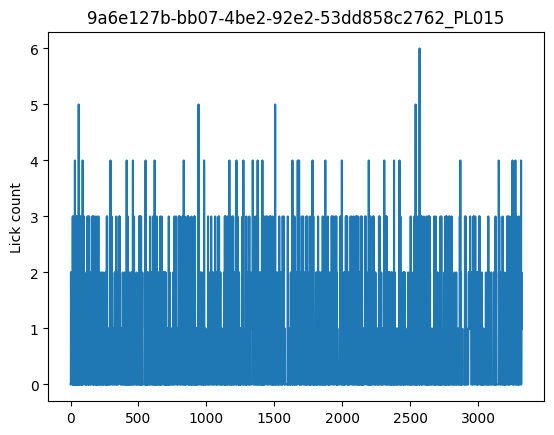

a4747ac8-6a75-444f-b99b-696fff0243fd_SWC_066


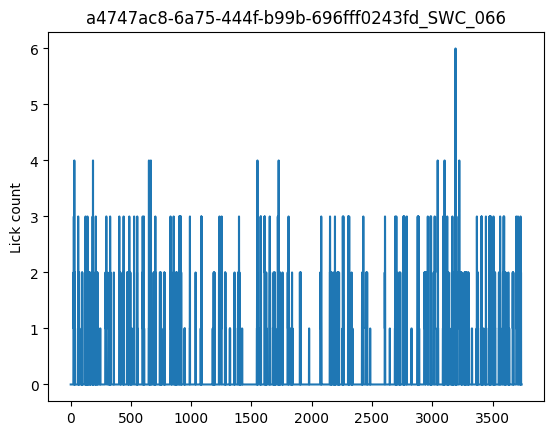

aa20388b-9ea3-4506-92f1-3c2be84b85db_DY_016


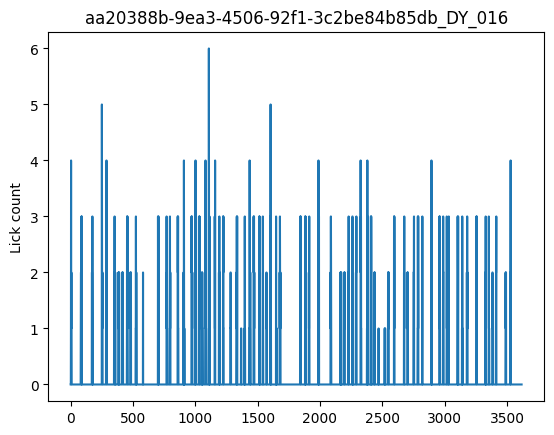

90e524a2-aa63-47ce-b5b8-1b1941a1223a_PL015


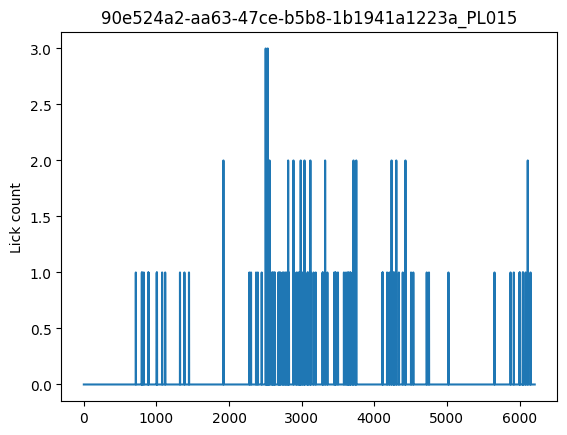

16693458-0801-4d35-a3f1-9115c7e5acfd_KS014


KeyboardInterrupt: 

In [6]:
for m, mat in enumerate(idxs):
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        # mouse_name = 'CSHL060'
        session = mat[0:36]
        
        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]  
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
        
        plt.plot(unnorm_mat['Lick count'])
        print(mat)
        plt.ylabel('Lick count')
        plt.title(mat)
        plt.show()


# Fit best params on individual sessions

best_results_Lick count_ZM_3003934dd7a4-fbdc-459c-8830-04fe9033bc28


/tmp/ipykernel_9591/3581429605.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

ZM_3003


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


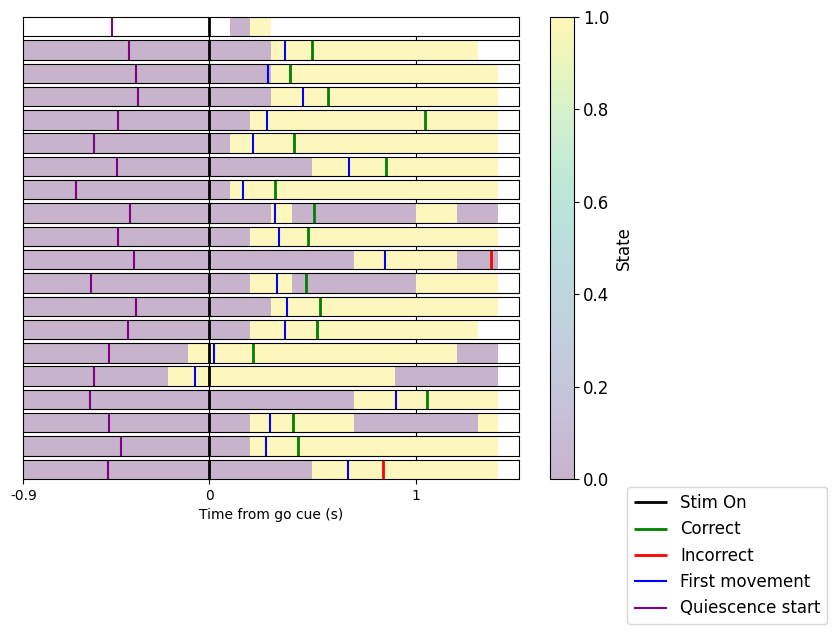

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:648: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


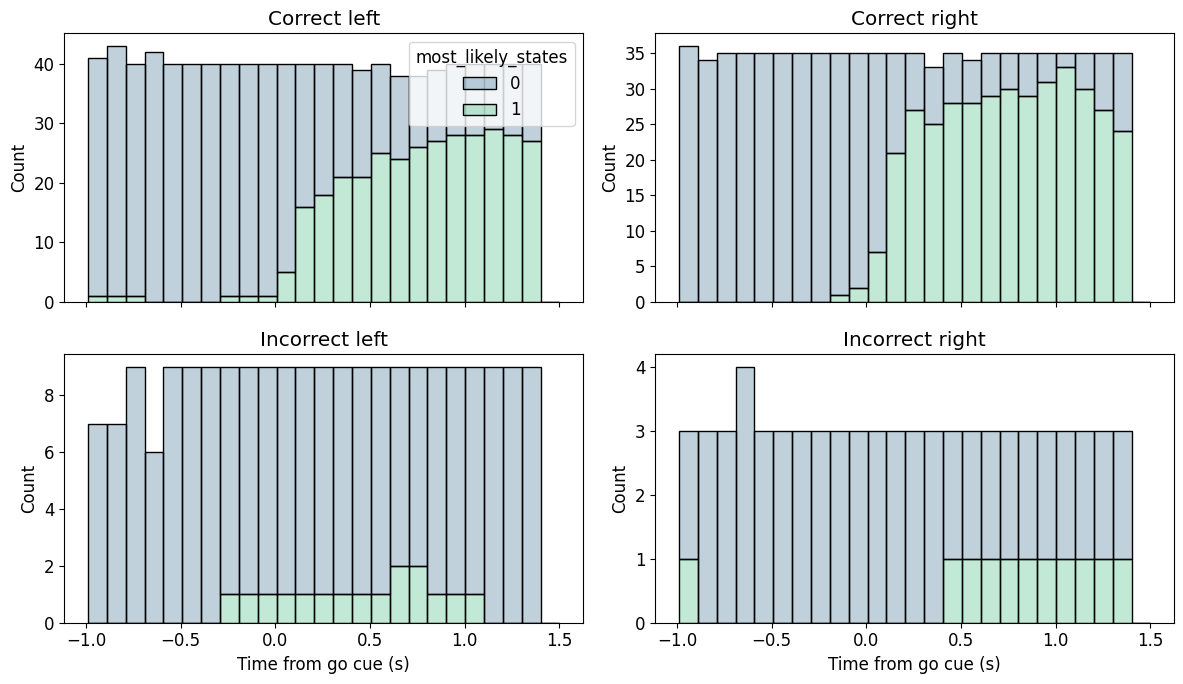

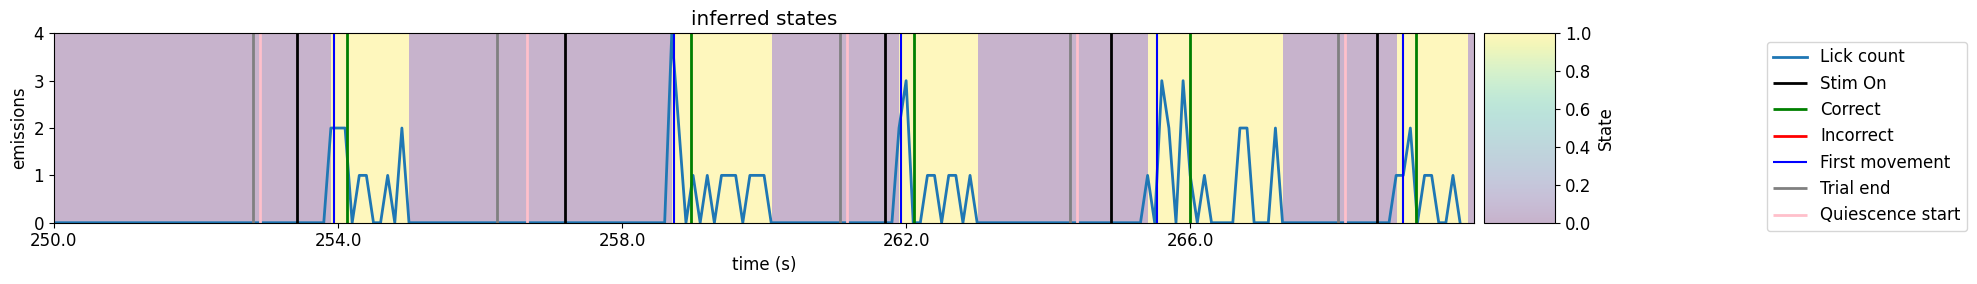

In [11]:
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

for m, mat in enumerate(idxs[0:1]): #
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        mouse_name = 'ZM_3003'
        session = mat[0:36]
        session = '934dd7a4-fbdc-459c-8830-04fe9033bc28'
        
        fit_id = str(mouse_name+session)
        if sticky:
            filename = "best_sticky_results_" + var_interest + '_' + fit_id
        else:
            filename = "best_results_" + var_interest + '_' + fit_id
        data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/90_trials/' + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'
        os.chdir(data_path)
        files = os.listdir()
        
        if filename in files:
            print(filename)
            # Get mouse data
            session_trials = session_all[mouse_name][session].reset_index()
            design_matrix = matrix_all[mouse_name][session][:,idx_init:idx_end]
            unnorm_mat = matrix_all_unnorm[mouse_name][session][var_names]
            unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']

            #try:
            all_lls, all_baseline_lls, all_init_params, all_fit_params, _, kappas = pickle.load(open(filename, "rb"))

            # Prepare data format
            num_timesteps = np.shape(design_matrix)[0]
            emission_dim = np.shape(design_matrix)[1]
            shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
            train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
            
            # Get best params and fold
            best_kappa, mean_bits_LL, best_fold = best__kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas)

            index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
            use_fold = int(best_fold[index_kappa])
            
            " Fit model with best params"
            
            best_params = all_fit_params[best_kappa]
            
            # Find parameters for best fold
            initial_probs = best_params[0].probs[use_fold]
            transition_matrix = best_params[1].transition_matrix[use_fold]
            emission_rates = best_params[2].rates[use_fold]      
            
            # Initialize new hmm
            test_phmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=best_kappa)
            best_fold_params, props = test_phmm.initialize(key=jr.PRNGKey(0), method=method,
                                            initial_probs=initial_probs,
                                            transition_matrix=transition_matrix,               
                                            emission_rates=emission_rates)  # not sure if I need to include  
            
            # Get state estimates for validation data
            most_likely_states = test_phmm.most_likely_states(best_fold_params, shortened_array)
            
   
            # Keep only enough states to explain 95% observations
            unique, counts = np.unique(most_likely_states, return_counts=True)
            threshold_count = threshold * len(most_likely_states)
            excluded_bins = 0
            remaining_states = list(counts.copy())
            for state in unique:
                size_smallest_state = np.nanmin(remaining_states)
                if size_smallest_state + excluded_bins < threshold_count:
                    remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                    excluded_bins += size_smallest_state
            
            # Remove states below threshold
            new_states = np.array(most_likely_states).astype(float)
            exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
            # Create a boolean mask to identify values to replace
            mask = np.isin(new_states, exclude_states)
            # Replace values in main_array with np.nan using the boolean mask
            new_states[mask] = np.nan
            
            
            new_states = most_likely_states
            
            " Plots "
            # Prepare data
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
            bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
            design_matrix_heading['Bin'] = bins
            
            # Fix discontinuities
            cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)
            
            # Align bins
            init = -1 * multiplier
            end = 1.5 * multiplier
            empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)


            print(mouse_name)
            """ Stack trial states """
            trial_init = 0  # First trial to plot
            trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
            inverted_mapping = []
            plot_states_aligned_trial(trial_init, empirical_data, cont_trials, bin_size, trials_to_plot, inverted_mapping)

            " Plot states stacked and aligned per trial type "
            plot_states_aligned(init, end, empirical_data, event_type_name, bin_size, inverted_mapping)
            
            # """ Plot states per trial epoch """
            # colors = sns.color_palette("viridis", num_states)
            # # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            # states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)
            # sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
            #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)
            # # plt.figure(figsize=[7, 5])
            # plt.xticks(rotation=45)
            # plt.tight_layout()
            
            # plt.title(mouse_name)
            # plt.show()

            """ Plot raw traces over states """
            init = 250*multiplier # First bin
            inter = 20*multiplier
            # traces_over_few_sates(init, empirical_data, session_trials, var_names)
            traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier, inverted_mapping)
                        
            #except:
            #    print(mat + 'not possible')

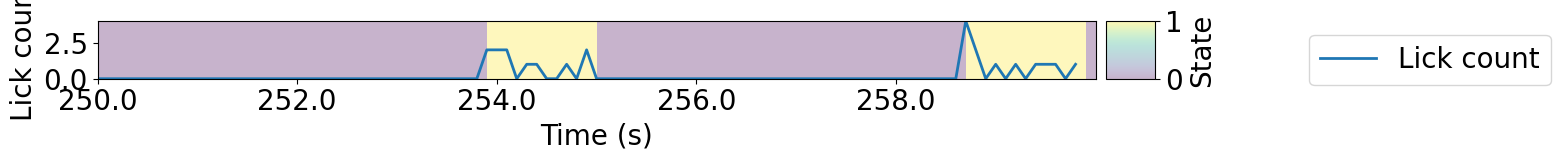

In [25]:
    # def traces_over_few_sates (init, inter, design_matrix, session_trials, columns_to_standardize, multiplier, inverted_mapping):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    design_matrix = empirical_data.copy()
    session_trials = cont_trials.copy()
    columns_to_standardize = var_names.copy()
    plt.rcParams.update({'font.size': 20})
    inter = 10*multiplier
    # Compute the most likely states
    
    end = init + inter

    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16, 2))

    df_normalized = design_matrix
    df_normalized['Bin'] = design_matrix['Bin']
    
    use_normalized = df_normalized.loc[(df_normalized['Bin']>init) & (df_normalized['Bin']<end)]
    
    # To make sure color code is used correctly
    number_of_states = len(use_normalized['most_likely_states'].unique()) - np.sum(np.isnan(use_normalized['most_likely_states'].unique()))
    states_to_append = np.arange(0, number_of_states, 1)
    
    # Plot original values
    if len(columns_to_standardize) == 2:
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[0]], label=columns_to_standardize[0], linewidth=2)
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[1]], label=columns_to_standardize[1], linewidth=2)
        plot_max = np.max([use_normalized[columns_to_standardize[0]], 
                           use_normalized[columns_to_standardize[1]]])
        plot_min = np.min([use_normalized[columns_to_standardize[0]], 
                           use_normalized[columns_to_standardize[1]]])
    elif len(columns_to_standardize) == 1:
        use_index0 = ~np.isnan(use_normalized[columns_to_standardize[0]])
        use_time = np.arange(0, len(use_index0), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!
        # axs.plot(use_normalized['Bin'][use_index0]-init, use_normalized[columns_to_standardize[0]][use_index0], label=columns_to_standardize[0], linewidth=2)
        axs.plot(use_time, use_normalized[columns_to_standardize[0]][use_index0], label=columns_to_standardize[0], linewidth=2)
        plot_max = np.max(use_normalized[columns_to_standardize[0]])
        plot_min = np.min(use_normalized[columns_to_standardize[0]])
    elif len(columns_to_standardize) == 3:
        use_index0 = ~np.isnan(use_normalized[columns_to_standardize[0]])
        use_time0 = np.arange(0, len(use_index0), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!
        use_index1 = ~np.isnan(use_normalized[columns_to_standardize[1]])
        use_time1 = np.arange(0, len(use_index1), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!
        use_index2 = ~np.isnan(use_normalized[columns_to_standardize[2]])
        use_time2 = np.arange(0, len(use_index2), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!

        axs.plot(use_time0, use_normalized[columns_to_standardize[0]], label=columns_to_standardize[0], linewidth=2)
        axs.plot(use_time1, use_normalized[columns_to_standardize[1]], label=columns_to_standardize[1], linewidth=2)
        axs.plot(use_time2, use_normalized[columns_to_standardize[2]], label=columns_to_standardize[2], linewidth=2)
        
        # axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[0]], label=columns_to_standardize[0], linewidth=2)
        # axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[1]], label=columns_to_standardize[1], linewidth=2)
        # axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[2]], label=columns_to_standardize[2], linewidth=2)
        plot_max = np.max([use_normalized[columns_to_standardize[0]], 
                           use_normalized[columns_to_standardize[1]],
                           use_normalized[columns_to_standardize[2]]])
        plot_min = np.min([use_normalized[columns_to_standardize[0]], 
                           use_normalized[columns_to_standardize[1]],
                           use_normalized[columns_to_standardize[2]]])
    elif len(columns_to_standardize) == 7:
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[0]], label=columns_to_standardize[0], linewidth=2)
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[1]], label=columns_to_standardize[1], linewidth=2)
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[2]], label=columns_to_standardize[2], linewidth=2)
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[3]], label=columns_to_standardize[3], linewidth=2)
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[4]], label=columns_to_standardize[4], linewidth=2)
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[5]], label=columns_to_standardize[5], linewidth=2)
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[6]], label=columns_to_standardize[6], linewidth=2)
        plot_max = np.max([use_normalized[columns_to_standardize[0]], 
                           use_normalized[columns_to_standardize[1]],
                           use_normalized[columns_to_standardize[2]],
                           use_normalized[columns_to_standardize[3]],
                           use_normalized[columns_to_standardize[4]],
                           use_normalized[columns_to_standardize[5]],
                           use_normalized[columns_to_standardize[6]]])
        plot_min = np.min([use_normalized[columns_to_standardize[0]], 
                           use_normalized[columns_to_standardize[1]],
                           use_normalized[columns_to_standardize[2]],
                           use_normalized[columns_to_standardize[3]],
                           use_normalized[columns_to_standardize[4]],
                           use_normalized[columns_to_standardize[5]],
                           use_normalized[columns_to_standardize[6]]])
    cax = axs.imshow(np.concatenate([use_normalized['most_likely_states'], states_to_append])[None,:], 
            extent=(0, len(np.concatenate([use_normalized['most_likely_states'], states_to_append])), plot_min, plot_max),
            aspect="auto",
            cmap='viridis',
            alpha=0.3) 

    divider = make_axes_locatable(axs)
    cax_colorbar = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(cax, cax=cax_colorbar, ax=axs)

    cbar.set_label('State')
    if len(inverted_mapping) > 0:
        # Set the ticks and labels based on the dictionary
        cbar.set_ticks(list(inverted_mapping.keys()))
        cbar.set_ticklabels(list(inverted_mapping.values()))

    # axs.hlines(0, init, end, color='Black', linestyles='dashed', linewidth=2)
    # axs.vlines(np.array(session_trials['goCueTrigger_times'] * 1*multiplier)-init, plot_min, plot_max, label='Stim On', 
    #            color='Black', linewidth=2)
    # axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 1*multiplier)-init, 
    #            plot_min, plot_max, label='Correct', color='Green', linewidth=2)
    # axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 1*multiplier)-init, 
    #            plot_min, plot_max, label='Incorrect', color='Red', linewidth=2)
    # axs.vlines(np.array(session_trials['firstMovement_times'] * 1*multiplier)-init, plot_min, plot_max, label='First movement', color='Blue')
    # axs.vlines(np.array(session_trials['intervals_0'] * 1*multiplier)-init, plot_min, plot_max, label='Trial end', color='Grey', linewidth=2)
    # axs.vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']) * 1*multiplier)-init, 
    #            plot_min, plot_max, label='Quiescence start', color='Pink', linewidth=2)

    axs.set_ylim(plot_min, plot_max)
    axs.set_ylabel("Lick count")
    axs.set_xlabel("Time (s)")
    axs.set_xlim(0, end-init)
    axs.set_xticks(np.arange(0, inter, inter/5),np.arange(init/multiplier, 
                                                          end/multiplier, (inter/multiplier)/5))
    # axs.set_title("inferred states")
    axs.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
    file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
    plt.savefig(file_path+'lick.svg', format="svg")

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_12965/3520027902.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_normalized['most_likely_states'] = (use_normalized['most_likely_states']-1) * -1


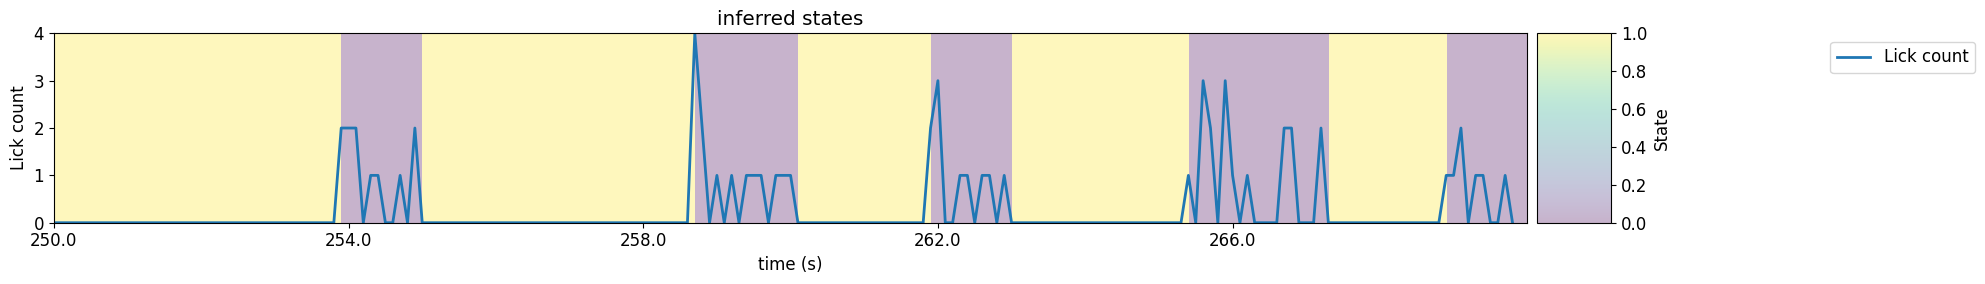

In [11]:
traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier, inverted_mapping)

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def traces_over_few_sates (init, inter, design_matrix, session_trials, columns_to_standardize, multiplier, inverted_mapping):
    # Compute the most likely states
    
    end = init + inter

    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(20, 3))

    df_normalized = design_matrix
    df_normalized['Bin'] = design_matrix['Bin']
    
    use_normalized = df_normalized.loc[(df_normalized['Bin']>init) & (df_normalized['Bin']<end)]
    
    # To make sure color code is used correctly
    number_of_states = len(use_normalized['most_likely_states'].unique()) - np.sum(np.isnan(use_normalized['most_likely_states'].unique()))
    states_to_append = np.arange(0, number_of_states, 1)
    
    # Plot original values
    if len(columns_to_standardize) == 2:
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[0]], label=columns_to_standardize[0], linewidth=2)
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[1]], label=columns_to_standardize[1], linewidth=2)
        plot_max = np.max([use_normalized[columns_to_standardize[0]], 
                           use_normalized[columns_to_standardize[1]]])
        plot_min = np.min([use_normalized[columns_to_standardize[0]], 
                           use_normalized[columns_to_standardize[1]]])
    elif len(columns_to_standardize) == 1:
        use_index0 = ~np.isnan(use_normalized[columns_to_standardize[0]])
        use_time = np.arange(0, len(use_index0), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!
        # axs.plot(use_normalized['Bin'][use_index0]-init, use_normalized[columns_to_standardize[0]][use_index0], label=columns_to_standardize[0], linewidth=2)
        axs.plot(use_time, use_normalized[columns_to_standardize[0]][use_index0], label=columns_to_standardize[0], linewidth=2)
        plot_max = np.max(use_normalized[columns_to_standardize[0]])
        plot_min = np.min(use_normalized[columns_to_standardize[0]])
    elif len(columns_to_standardize) == 3:
        use_index0 = ~np.isnan(use_normalized[columns_to_standardize[0]])
        use_time0 = np.arange(0, len(use_index0), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!
        use_index1 = ~np.isnan(use_normalized[columns_to_standardize[1]])
        use_time1 = np.arange(0, len(use_index1), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!
        use_index2 = ~np.isnan(use_normalized[columns_to_standardize[2]])
        use_time2 = np.arange(0, len(use_index2), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!

        axs.plot(use_time0, use_normalized[columns_to_standardize[0]], label=columns_to_standardize[0], linewidth=2)
        axs.plot(use_time1, use_normalized[columns_to_standardize[1]], label=columns_to_standardize[1], linewidth=2)
        axs.plot(use_time2, use_normalized[columns_to_standardize[2]], label=columns_to_standardize[2], linewidth=2)
        
        # axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[0]], label=columns_to_standardize[0], linewidth=2)
        # axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[1]], label=columns_to_standardize[1], linewidth=2)
        # axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[2]], label=columns_to_standardize[2], linewidth=2)
        plot_max = np.max([use_normalized[columns_to_standardize[0]], 
                           use_normalized[columns_to_standardize[1]],
                           use_normalized[columns_to_standardize[2]]])
        plot_min = np.min([use_normalized[columns_to_standardize[0]], 
                           use_normalized[columns_to_standardize[1]],
                           use_normalized[columns_to_standardize[2]]])
    elif len(columns_to_standardize) == 4:
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[0]], label=columns_to_standardize[0], linewidth=2)
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[1]], label=columns_to_standardize[1], linewidth=2)
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[2]], label=columns_to_standardize[2], linewidth=2)
        axs.plot(use_normalized['Bin']-init, use_normalized[columns_to_standardize[3]], label=columns_to_standardize[3], linewidth=2)
        plot_max = np.max([use_normalized[columns_to_standardize[0]], 
                           use_normalized[columns_to_standardize[1]],
                           use_normalized[columns_to_standardize[2]],
                           use_normalized[columns_to_standardize[3]]])
        plot_min = np.min([use_normalized[columns_to_standardize[0]], 
                           use_normalized[columns_to_standardize[1]],
                           use_normalized[columns_to_standardize[2]],
                           use_normalized[columns_to_standardize[3]]])
    use_normalized['most_likely_states'] = (use_normalized['most_likely_states']-1) * -1
    cax = axs.imshow(np.concatenate([use_normalized['most_likely_states'], states_to_append])[None,:], 
            extent=(0, len(np.concatenate([use_normalized['most_likely_states'], states_to_append])), plot_min, plot_max),
            aspect="auto",
            cmap='viridis',
            alpha=0.3) 

    divider = make_axes_locatable(axs)
    cax_colorbar = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(cax, cax=cax_colorbar, ax=axs)

    cbar.set_label('State')
    if len(inverted_mapping) > 0:
        # Set the ticks and labels based on the dictionary
        cbar.set_ticks(list(inverted_mapping.keys()))
        cbar.set_ticklabels(list(inverted_mapping.values()))

    # axs.hlines(0, init, end, color='Black', linestyles='dashed', linewidth=2)
    # axs.vlines(np.array(session_trials['goCueTrigger_times'] * 1*multiplier)-init, plot_min, plot_max, label='Stim On', 
    #            color='Black', linewidth=2)
    # axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 1*multiplier)-init, 
    #            plot_min, plot_max, label='Correct', color='Green', linewidth=2)
    # axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 1*multiplier)-init, 
    #            plot_min, plot_max, label='Incorrect', color='Red', linewidth=2)
    # axs.vlines(np.array(session_trials['firstMovement_times'] * 1*multiplier)-init, plot_min, plot_max, label='First movement', color='Blue')
    # axs.vlines(np.array(session_trials['intervals_0'] * 1*multiplier)-init, plot_min, plot_max, label='Trial end', color='Grey', linewidth=2)
    # axs.vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']) * 1*multiplier)-init, 
    #            plot_min, plot_max, label='Quiescence start', color='Pink', linewidth=2)

    axs.set_ylim(plot_min, plot_max)
    axs.set_ylabel("Lick count")
    axs.set_xlabel("time (s)")
    axs.set_xlim(0, end-init)
    axs.set_xticks(np.arange(0, inter, inter/5),np.arange(init/multiplier, 
                                                          end/multiplier, (inter/multiplier)/5))
    axs.set_title("inferred states")
    axs.legend(loc='upper left', bbox_to_anchor=(1.2, 1))

    plt.tight_layout()
    plt.show()
    


## Parameters

In [11]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'
threshold = 0.05

num_states = 2
kappa = 0


/tmp/ipykernel_65578/1903062713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


2


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:501: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


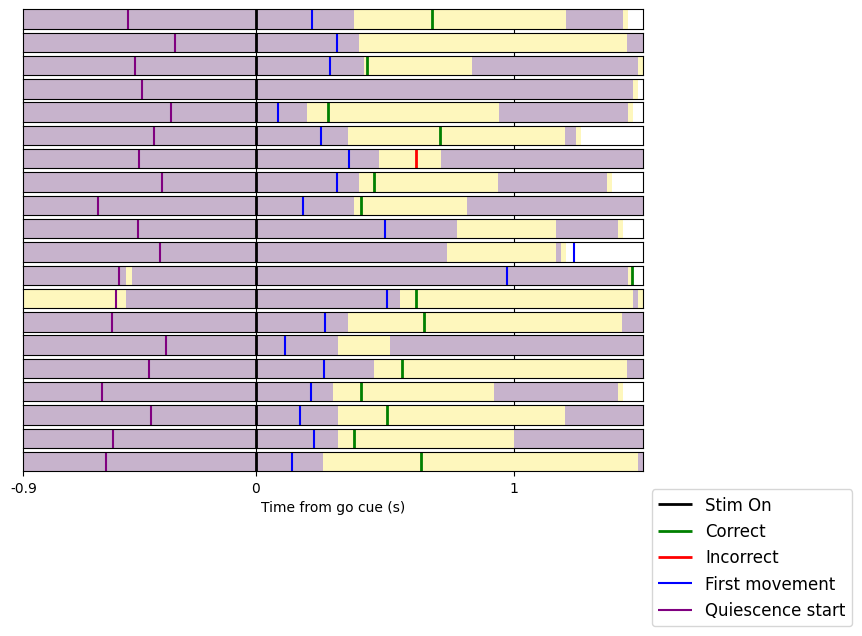

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


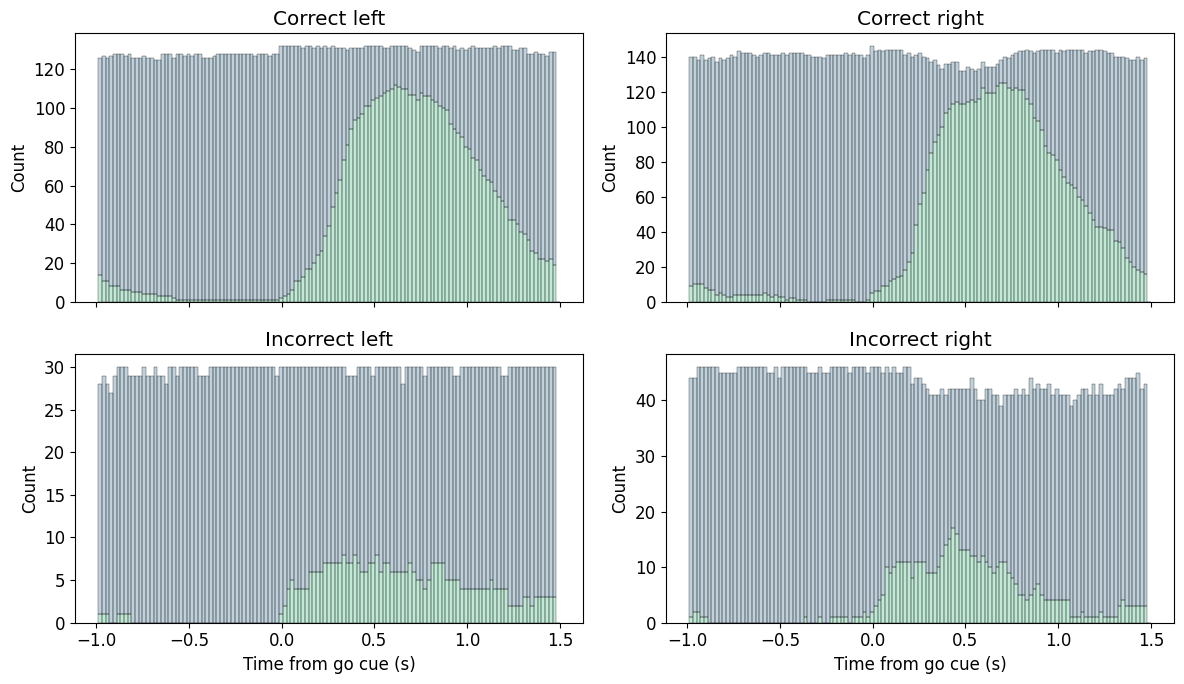

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:280: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:281: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plot

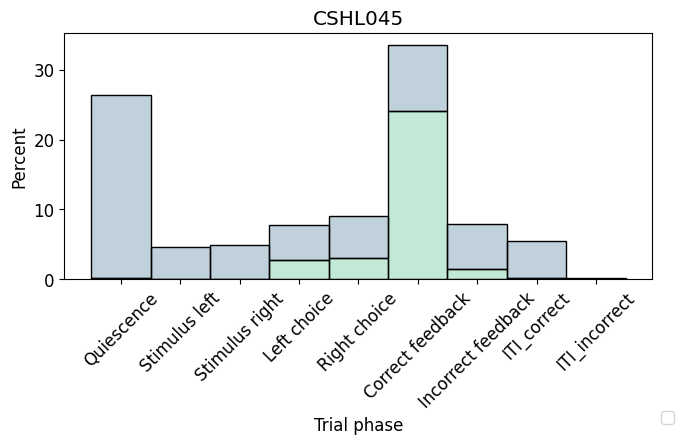

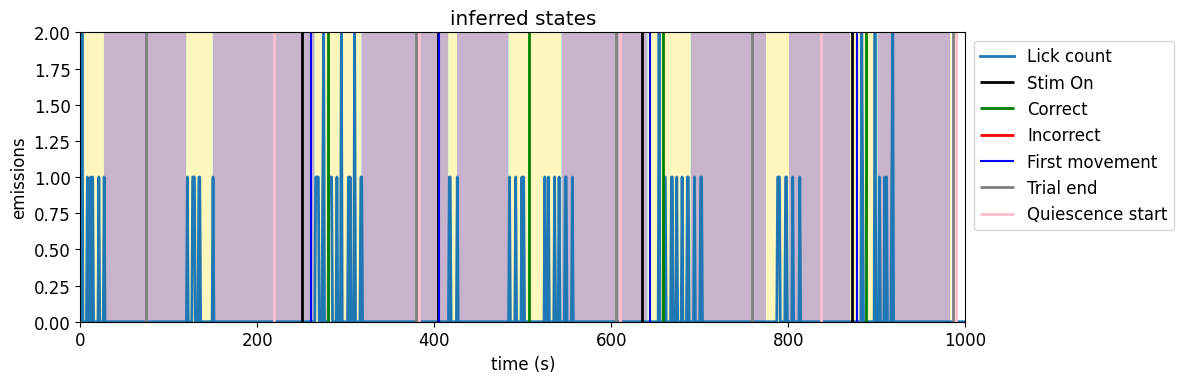

/tmp/ipykernel_65578/1903062713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


3


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:501: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


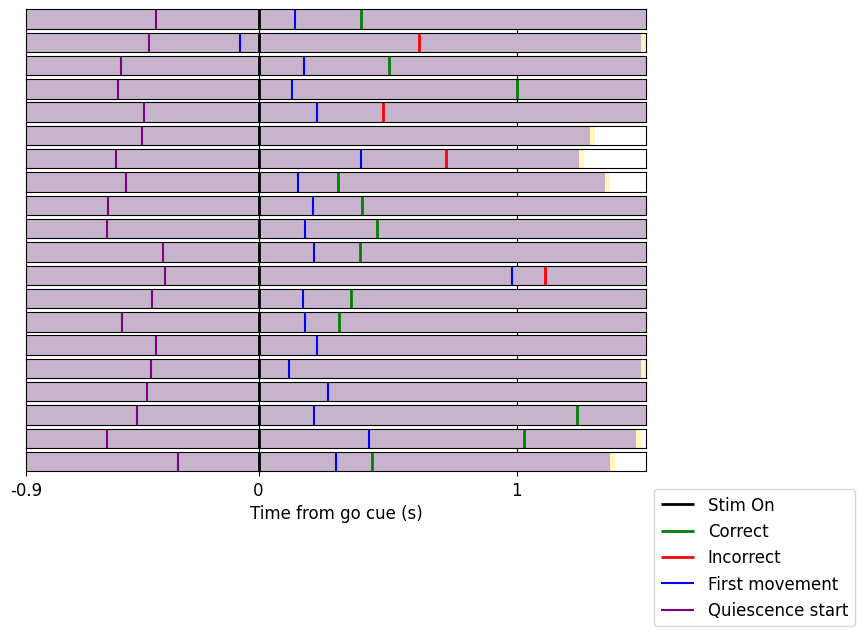

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


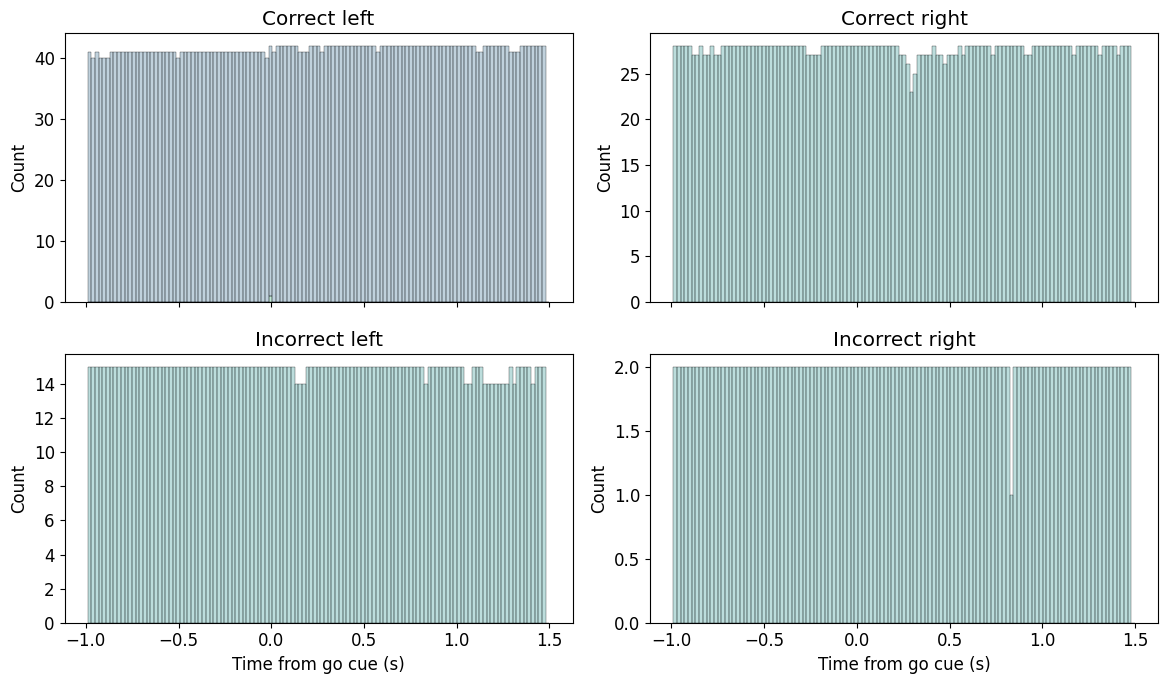

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:280: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:281: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plot

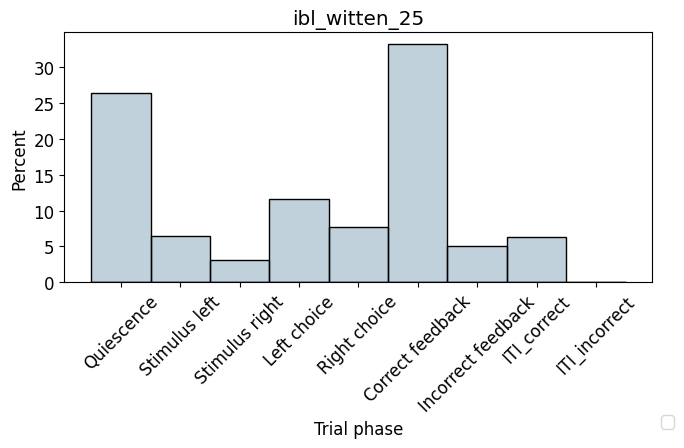

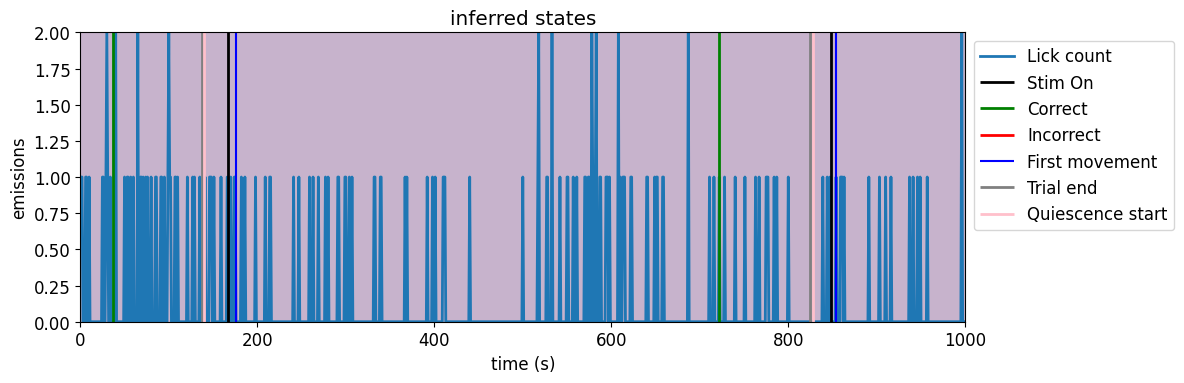

/tmp/ipykernel_65578/1903062713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


4


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:501: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


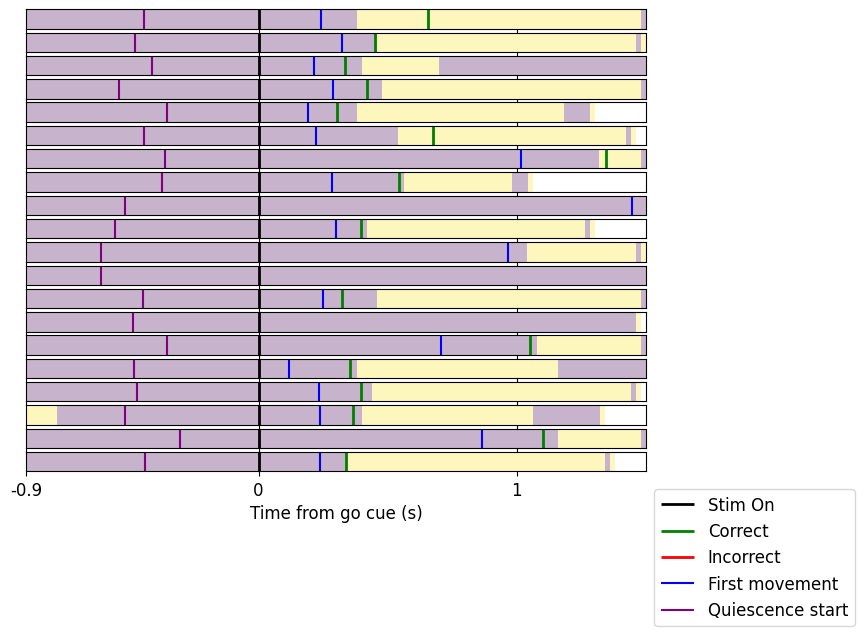

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


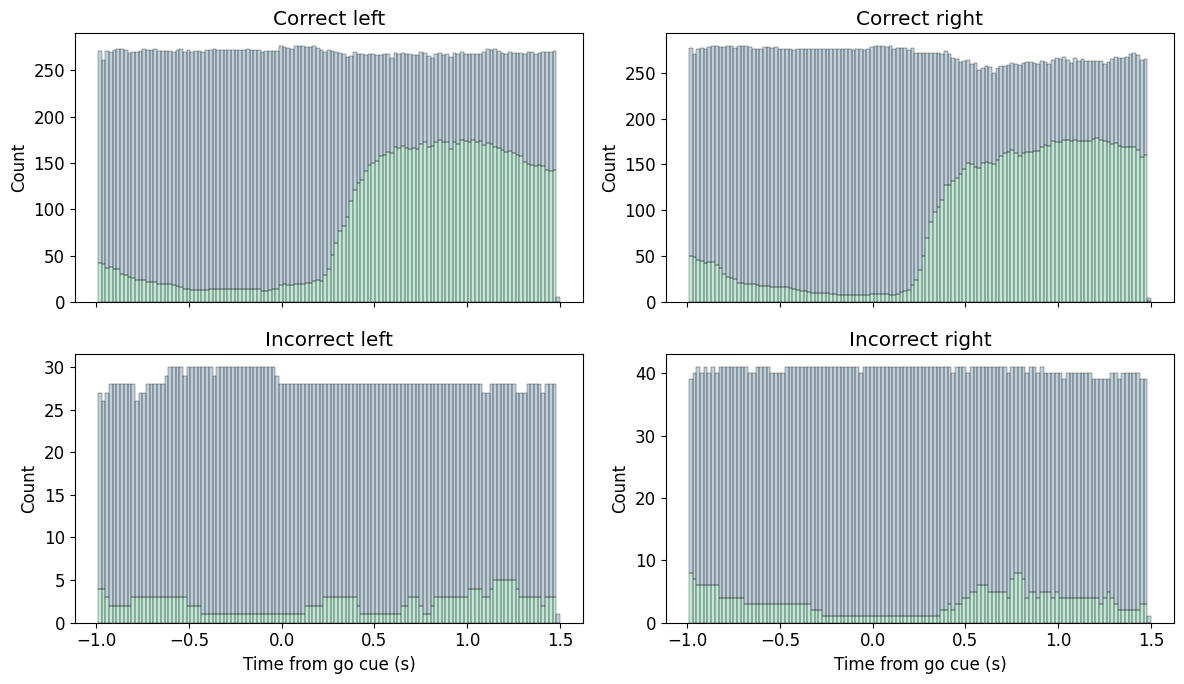

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:280: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:281: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plot

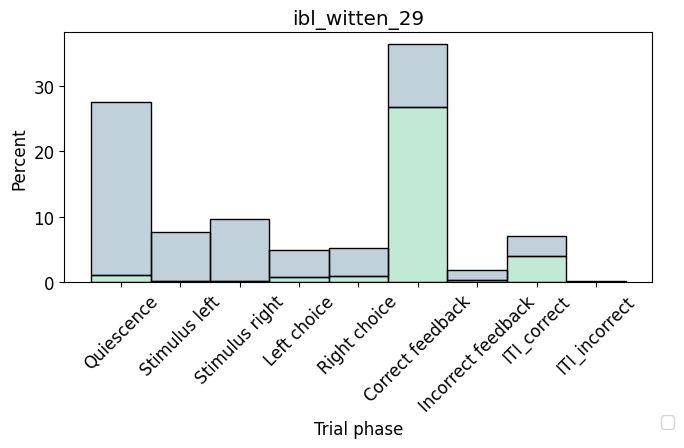

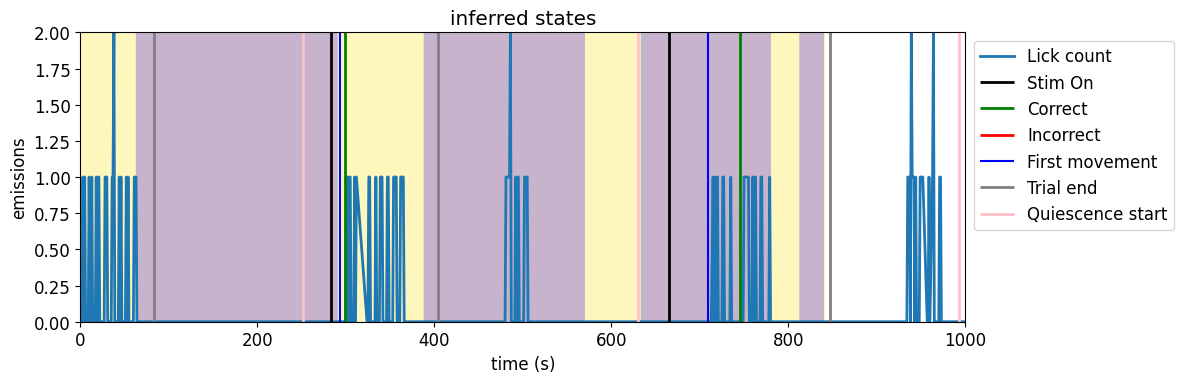

/tmp/ipykernel_65578/1903062713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


4


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:501: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


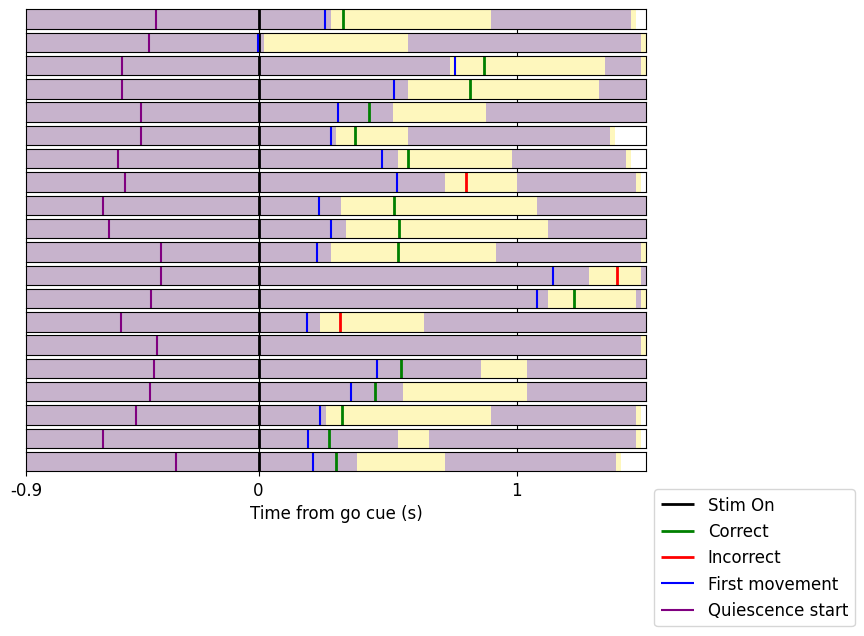

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


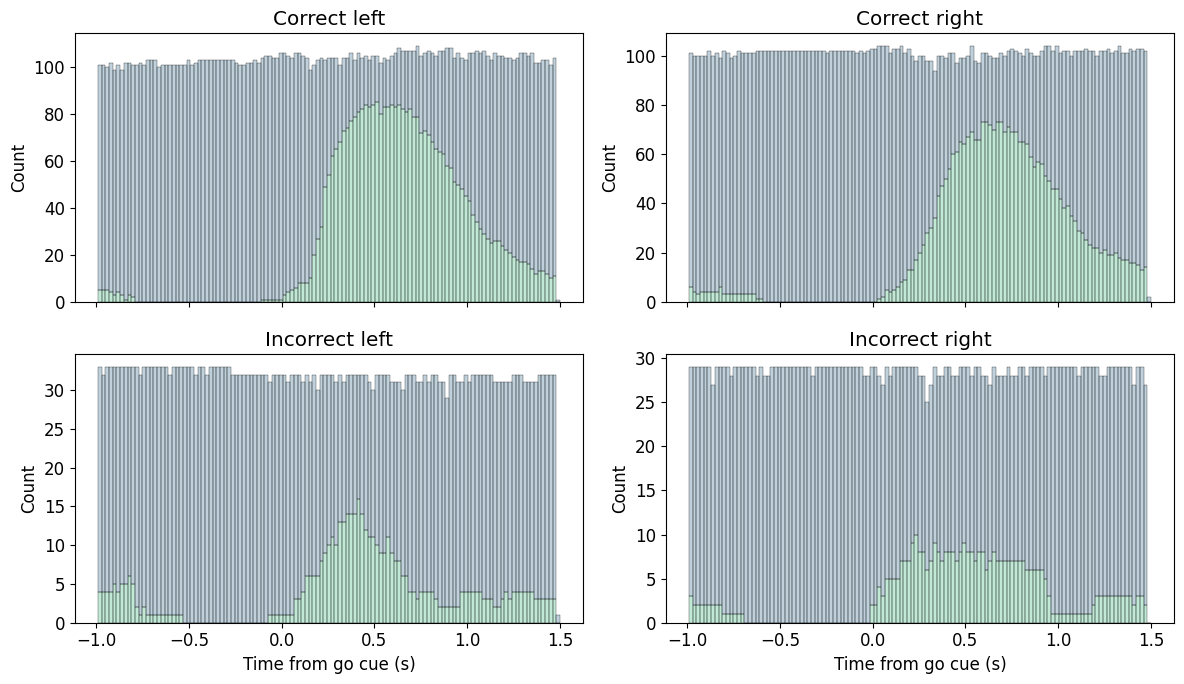

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:280: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:281: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plot

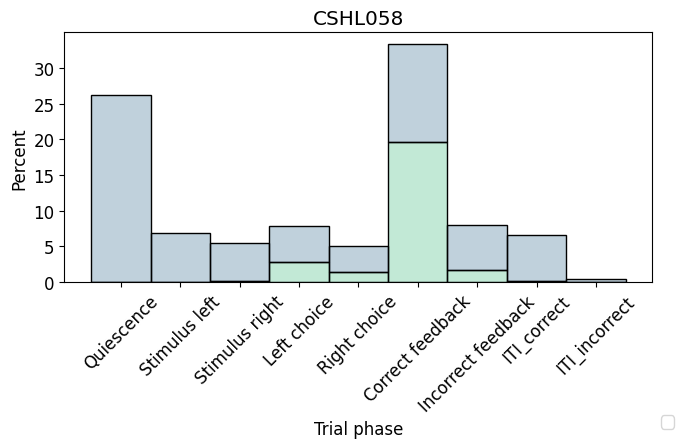

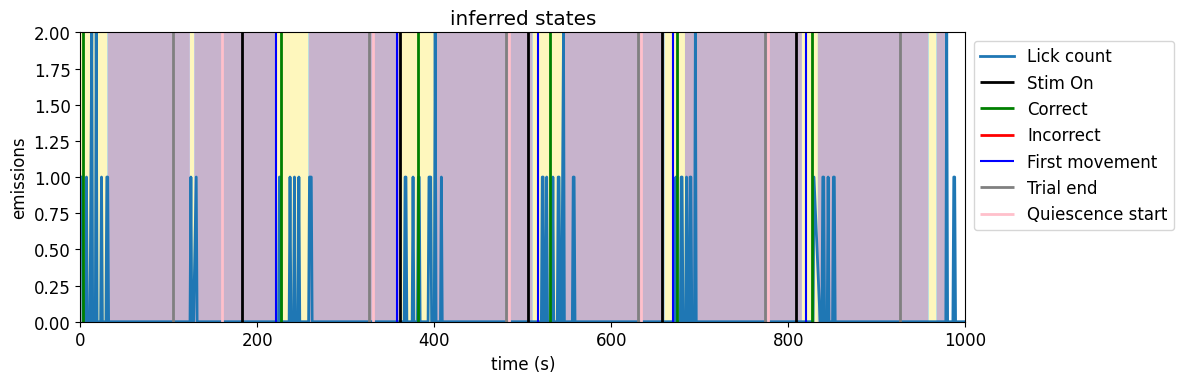

/tmp/ipykernel_65578/1903062713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


4


KeyboardInterrupt: 

In [9]:
for m, mouse_name in enumerate(mouse_names):
    
    index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
    idx_init = idx_init_list[index_var]
    idx_end = idx_end_list[index_var]
    var_names = use_sets[index_var]
    
    # Get mouse data
    session_trials = collapsed_trials[mouse_name]
    design_matrix = collapsed_matrices[mouse_name][:,idx_init:idx_end]
    unnorm_mat = collapsed_unnorm[mouse_name][var_names]
    unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']

    " Fit model with cross-validation"
    # Prepare data for cross-validation
    num_timesteps = np.shape(design_matrix)[0]
    emission_dim = np.shape(design_matrix)[1]
    shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

    # Initialize model with Kmeans
    test_phmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=kappa)
    init_params, props = test_phmm.initialize(key=jr.PRNGKey(1))  # for now all data
    
    # Fit model to all data with cross-validation
    val_lls, fit_params, init_params, baseline_lls = cross_validate_poismodel(test_phmm, 
                                                                            jr.PRNGKey(0), shortened_array, 
                                                                            train_emissions, num_train_batches)
    " Re-fit with parameters of best fold "
    # Find best fold
    use_fold = np.where(val_lls==np.nanmax(val_lls))[0][0]
    print(use_fold)
    
    # Find parameters for best fold
    initial_probs = fit_params[0].probs[use_fold]
    transition_matrix = fit_params[1].transition_matrix[use_fold]
    emission_rates = fit_params[2].rates[use_fold]     
    
    # Initialize new hmm
    new_bhmm = PoissonHMM(num_states, emission_dim)
    best_fold_params, props = new_bhmm.initialize(key=jr.PRNGKey(0), method=method,
                                    initial_probs=initial_probs,
                                    transition_matrix=transition_matrix,               
                                    emission_rates=emission_rates) 
    
    # Get state estimates for validation data
    most_likely_states = new_bhmm.most_likely_states(best_fold_params, shortened_array)

    # Keep only enough states to explain 95% observations
    unique, counts = np.unique(most_likely_states, return_counts=True)
    threshold_count = threshold * len(most_likely_states)
    excluded_bins = 0
    remaining_states = list(counts.copy())
    for state in unique:
        size_smallest_state = np.nanmin(remaining_states)
        if size_smallest_state + excluded_bins < threshold_count:
            remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
            excluded_bins += size_smallest_state
    
    # Remove states below threshold
    new_states = np.array(most_likely_states).astype(float)
    exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
    # Create a boolean mask to identify values to replace
    mask = np.isin(new_states, exclude_states)
    # Replace values in main_array with np.nan using the boolean mask
    new_states[mask] = np.nan
    new_states = most_likely_states
    
    # Prepare data
    design_matrix_heading = pd.DataFrame(columns=var_names)
    design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
    bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
    design_matrix_heading['Bin'] = bins
    
    # Fix discontinuities
    cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)

    # Align bins
    init = -1 * multiplier
    end = 1.5 * multiplier
    empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)

    """ Stack trial states """
    trial_init = 30  # First trial to plot
    trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
    plot_states_aligned_trial(trial_init, empirical_data, cont_trials, bin_size, trials_to_plot, num_states)

    " Plot states stacked and aligned per trial type "
    plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
    
    """ Plot states per trial epoch """
    colors = sns.color_palette("viridis", num_states)
    # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
    states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)

    plt.figure(figsize=[7, 5])
    sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
                        multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
    plt.xlabel('Trial phase')
    plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(mouse_name)
    plt.show()

    """ Plot raw traces over states """
    init = 250*multiplier # First bin
    inter = 20*multiplier
    # traces_over_few_sates(init, empirical_data, session_trials, var_names)
    traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier)
    

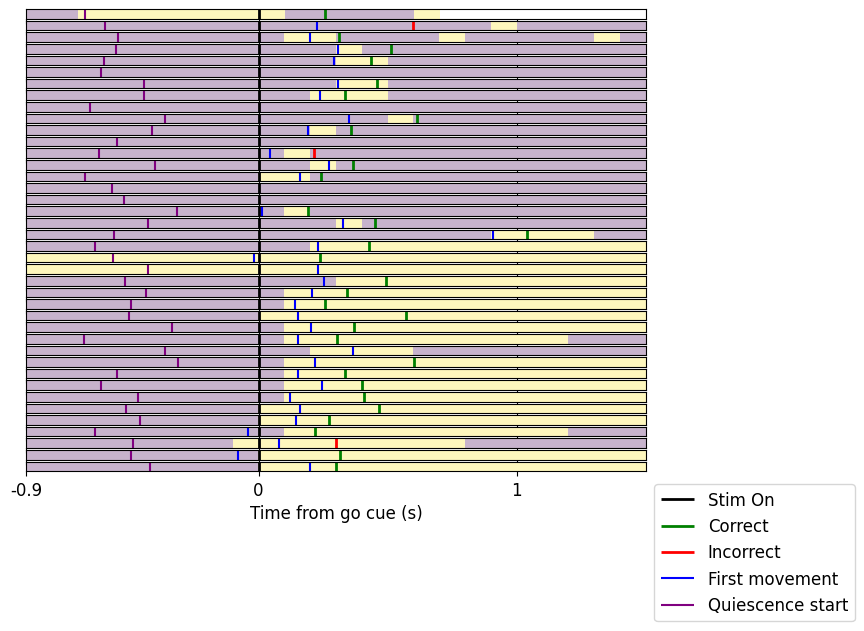

In [52]:
""" Stack trial states """
trial_init = 0  # First trial to plot
trials_to_plot = 40  # How many trials to plot (if very different will compromise readibility)
plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, num_states)


## Fit best params

In [18]:
filename in files

False

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


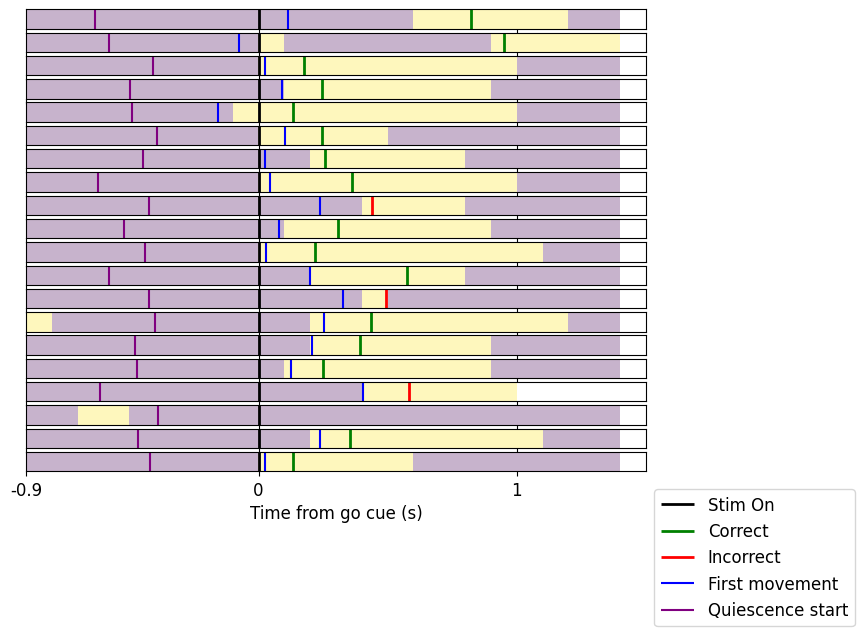

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


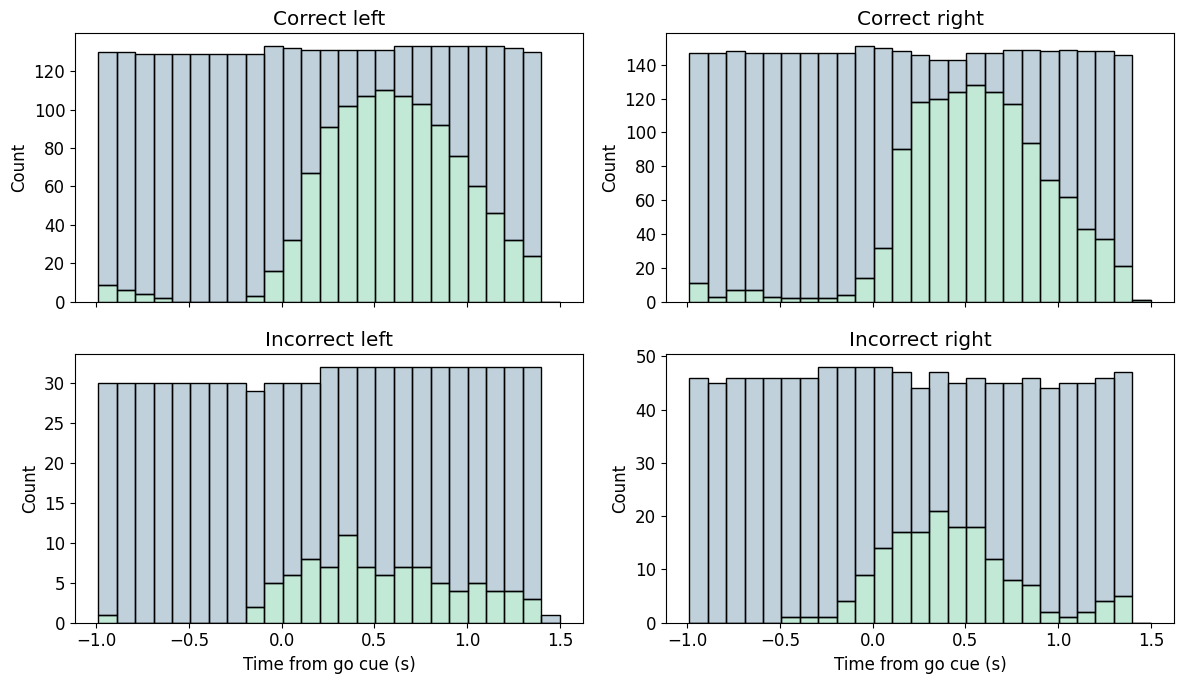

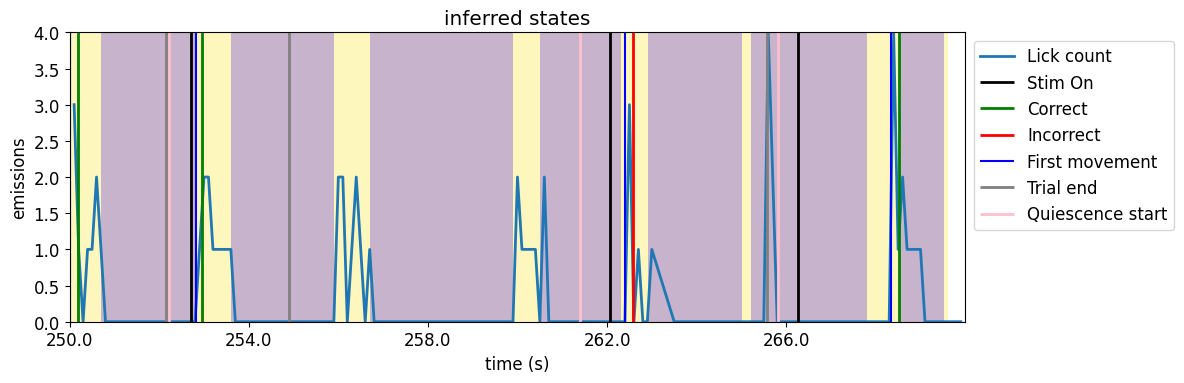

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to 

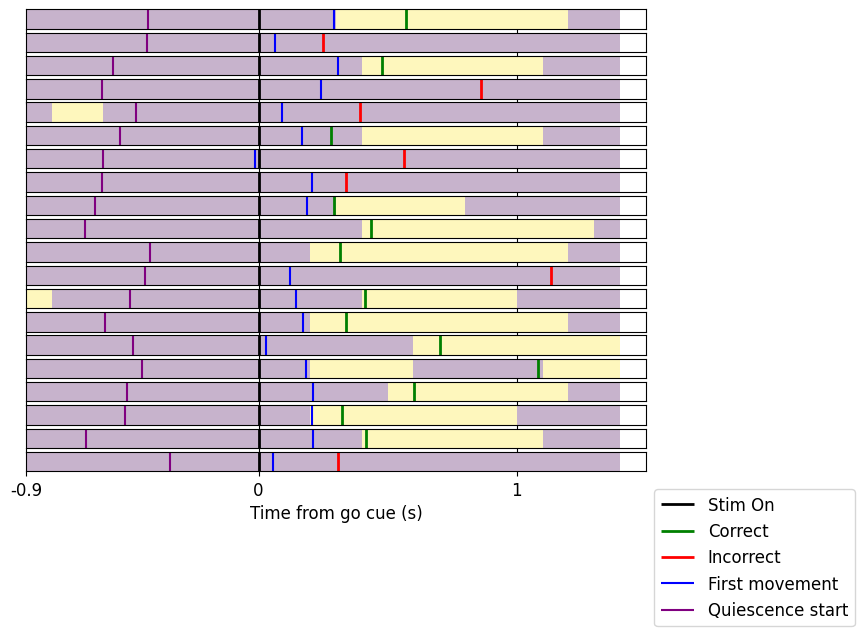

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


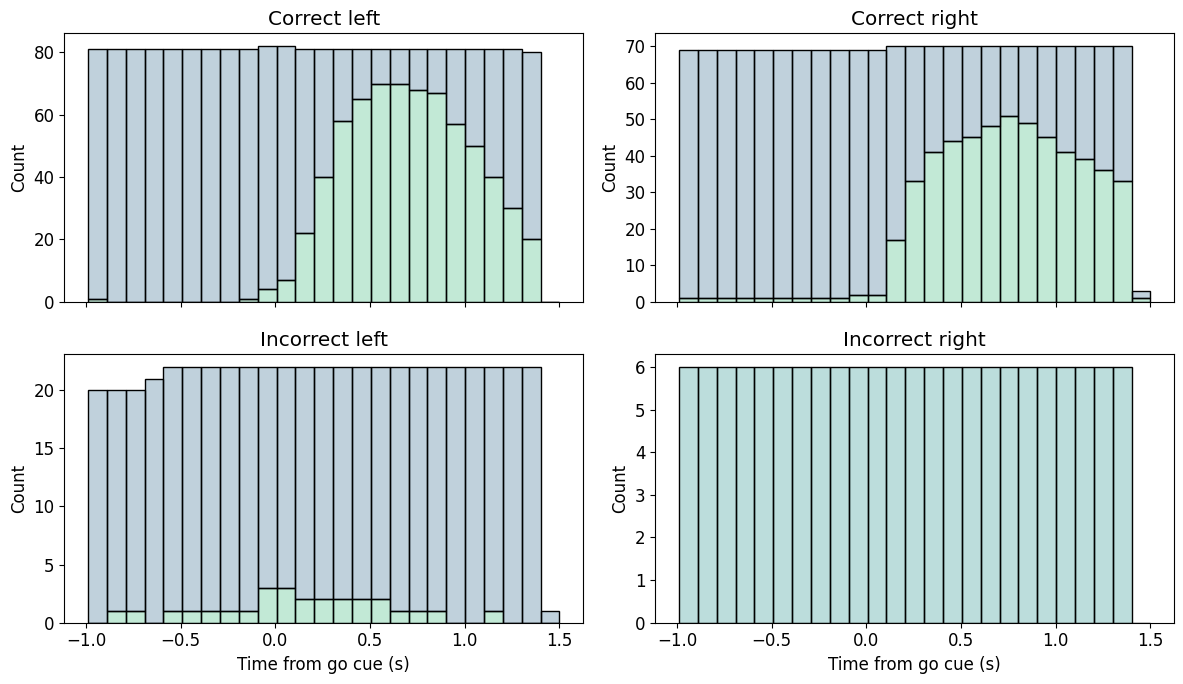

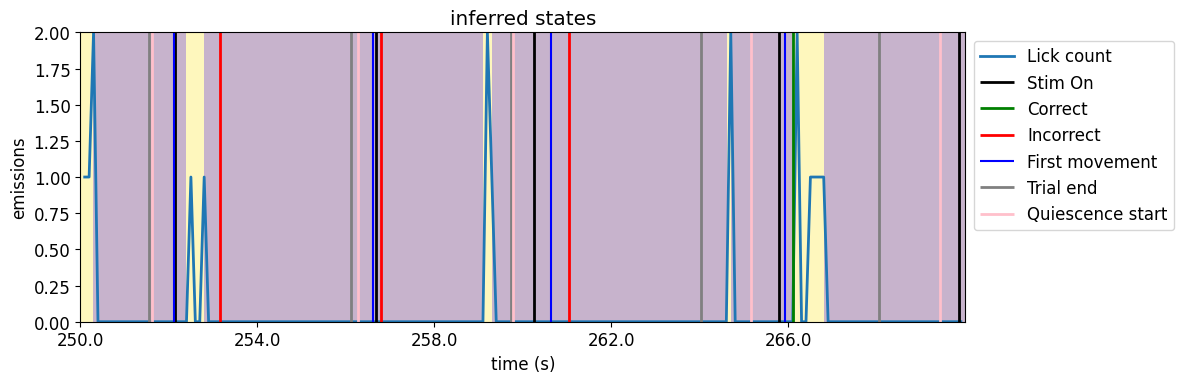

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


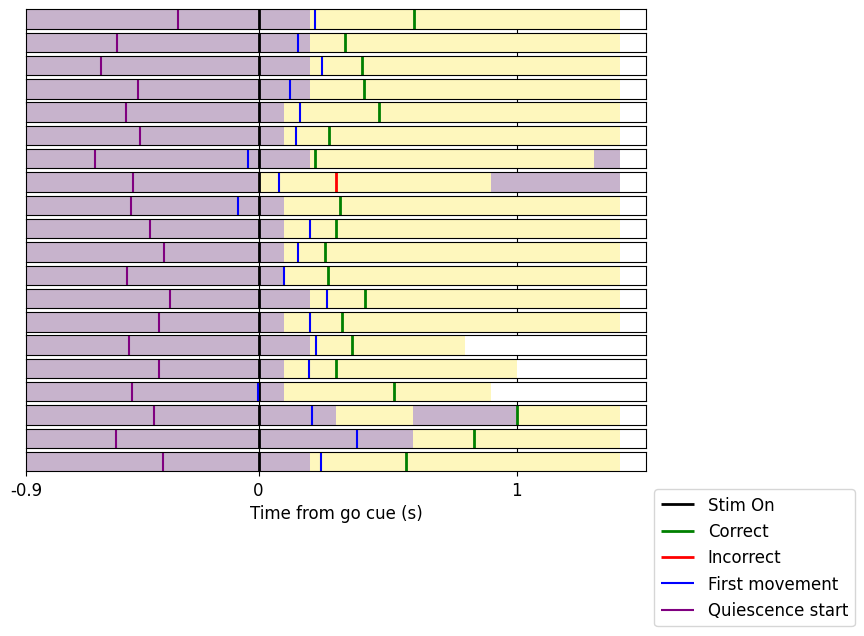

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


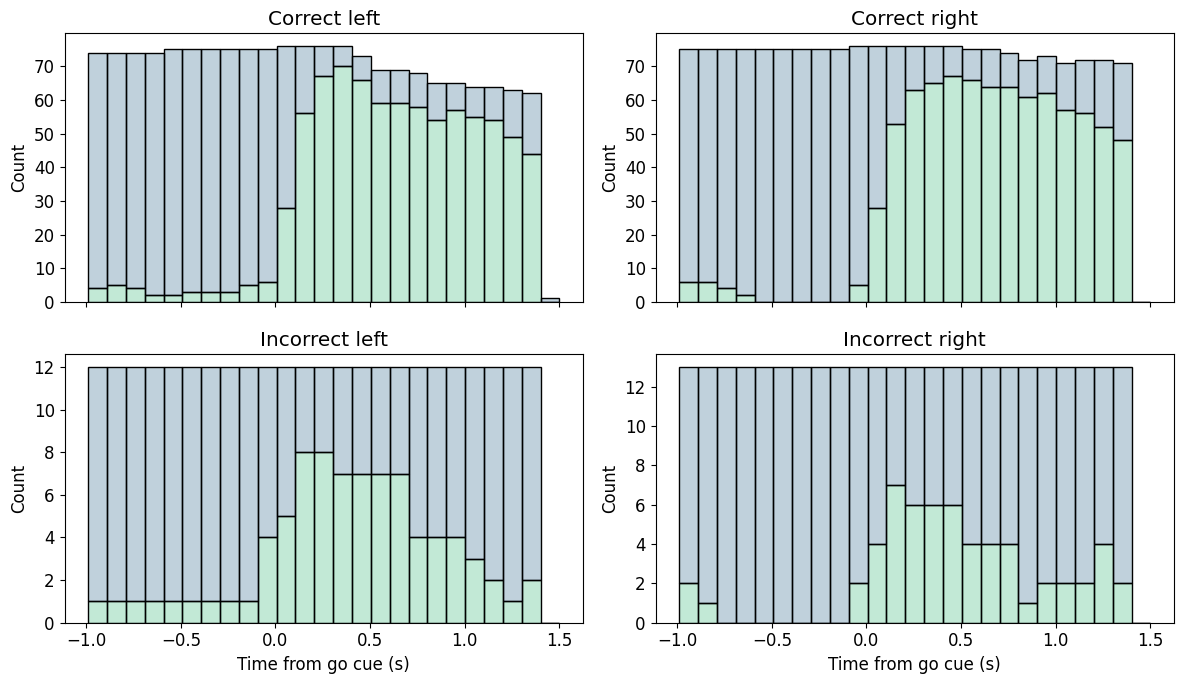

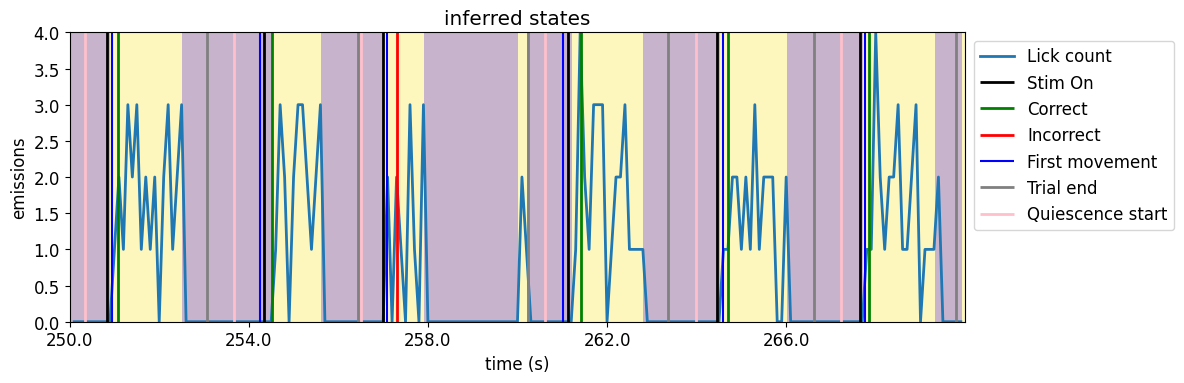

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to 

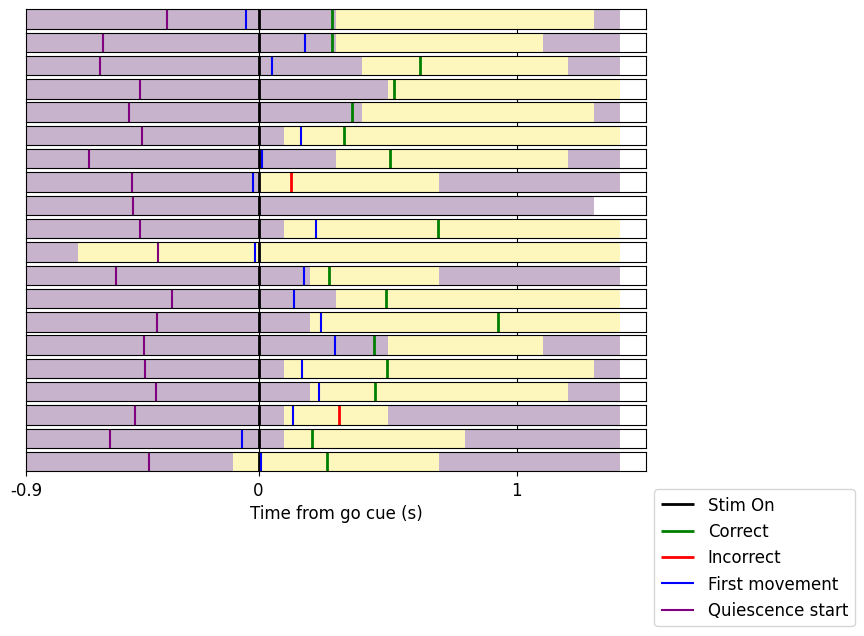

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


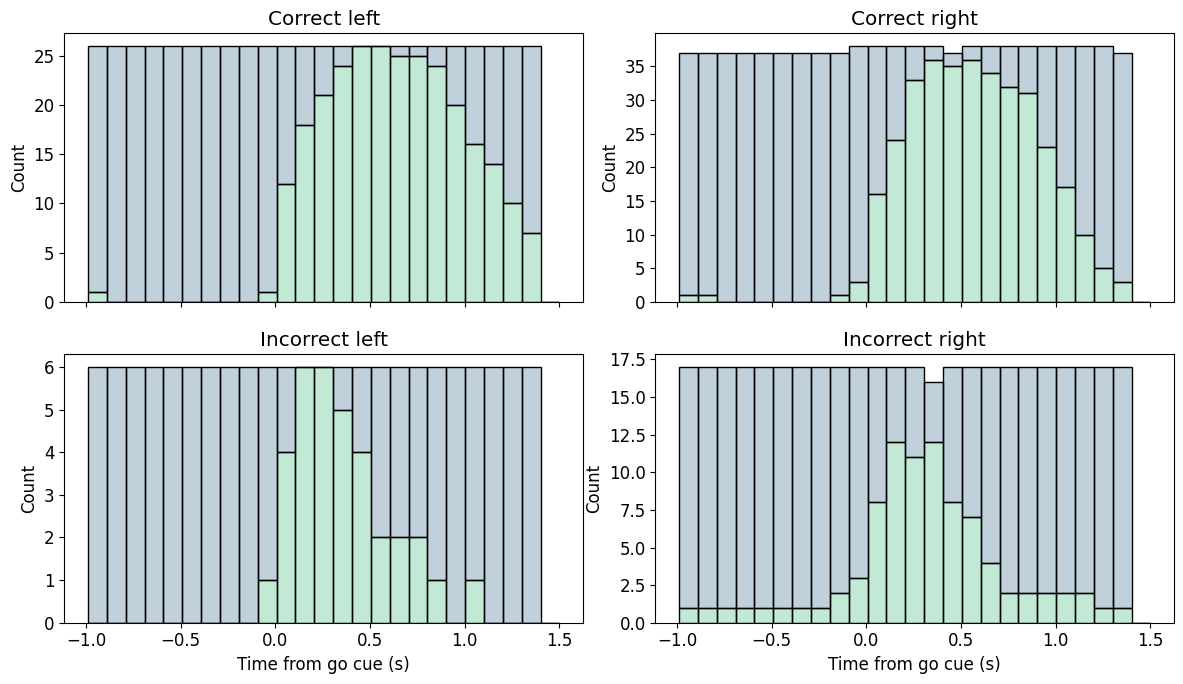

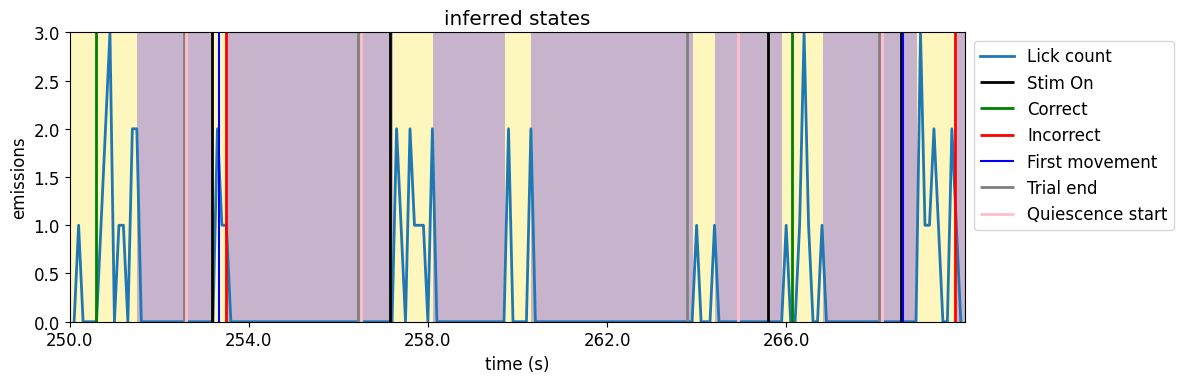

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


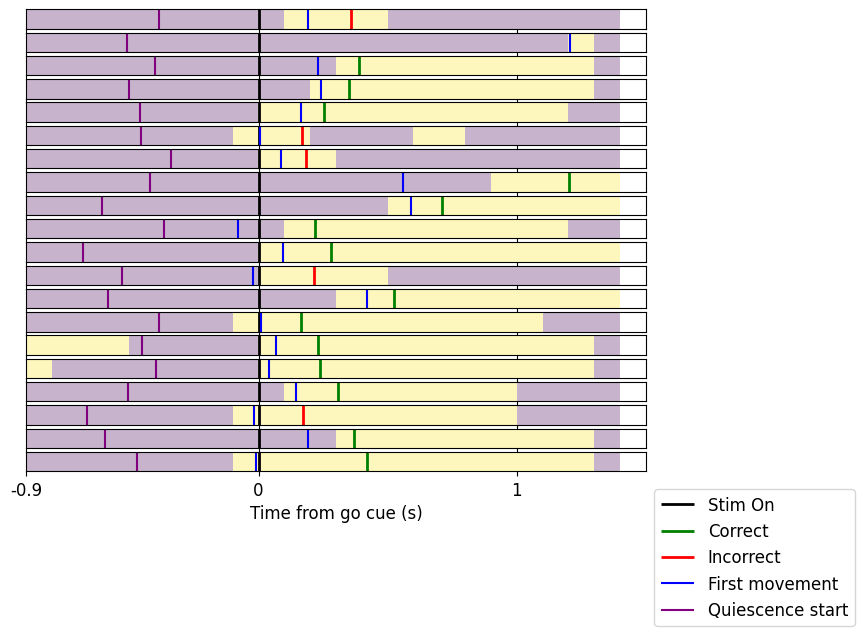

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


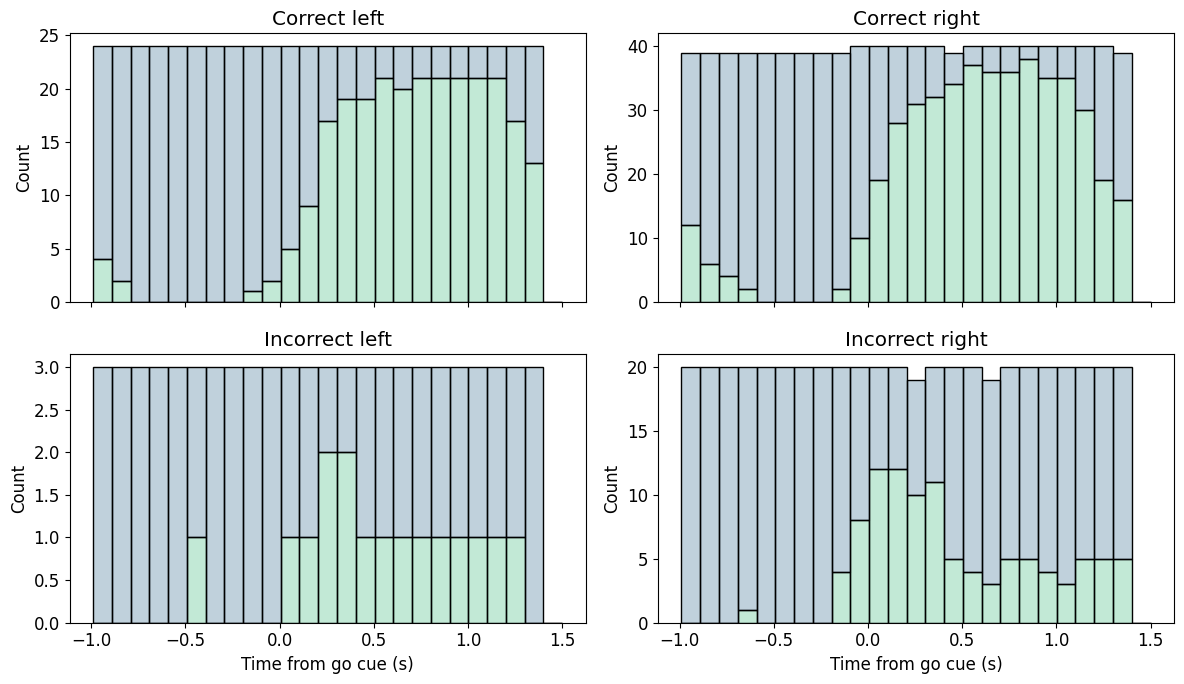

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:741: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  axs.imshow(np.concatenate([use_normalized['most_likely_states'], states_to_append])[None,:],
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


CSHL052


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


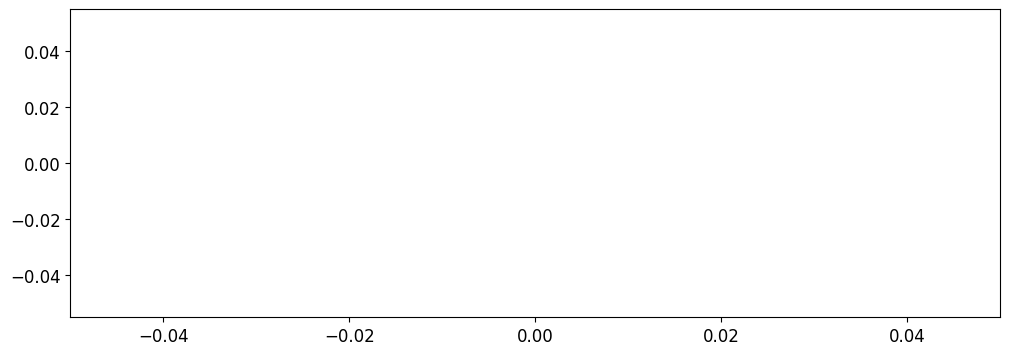

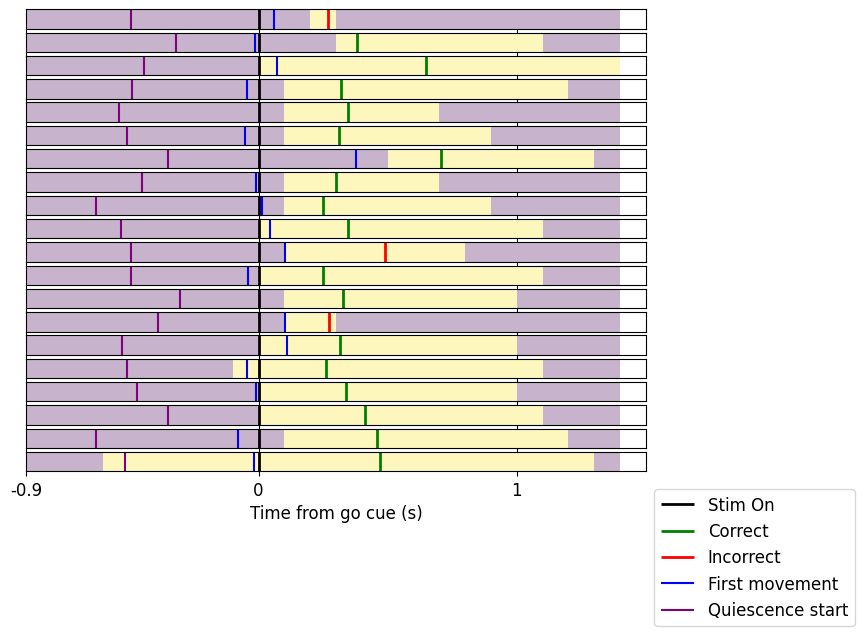

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


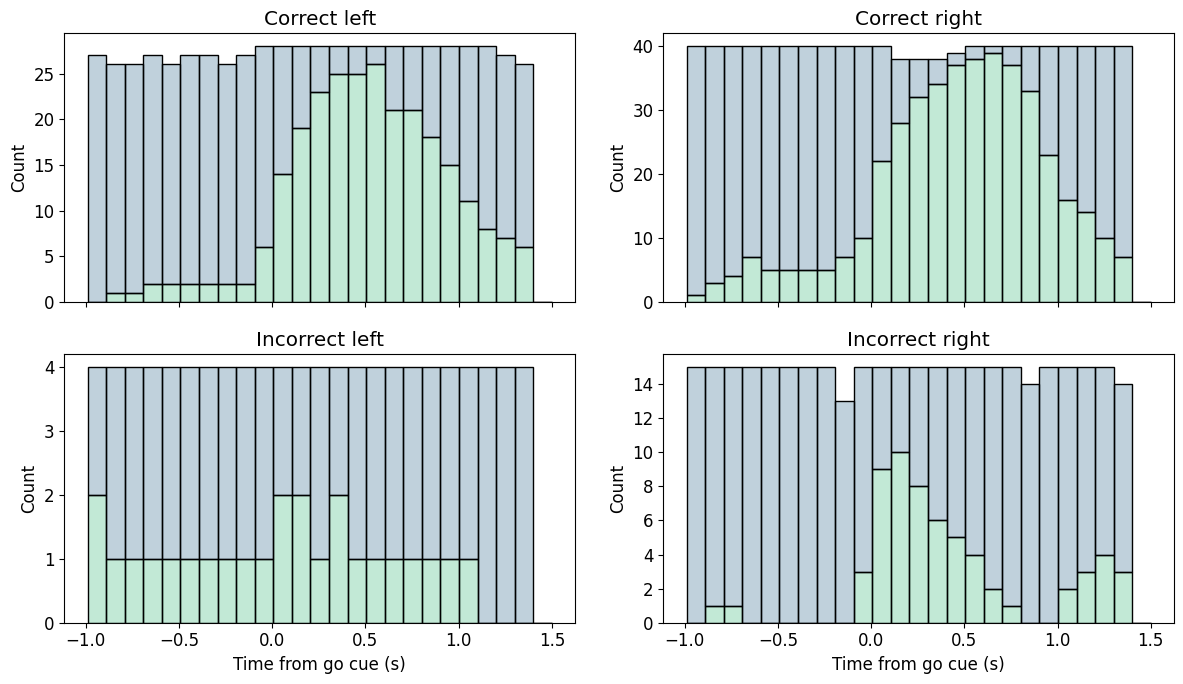

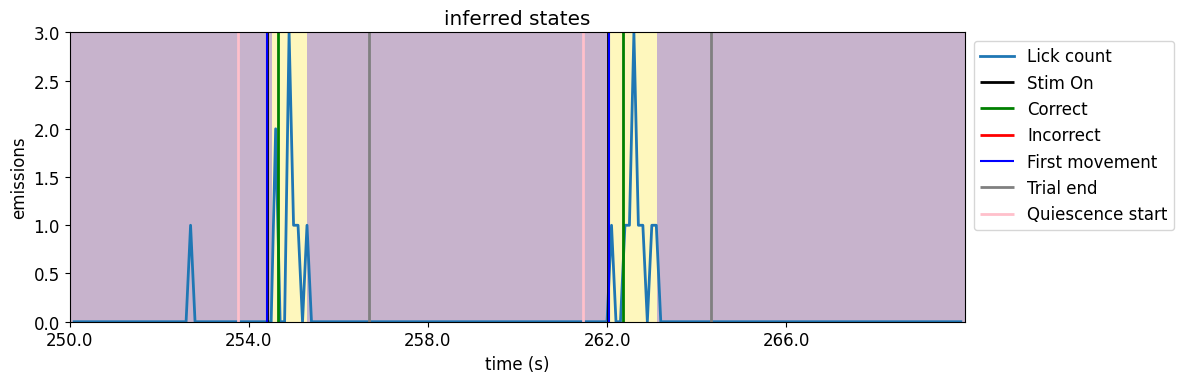

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


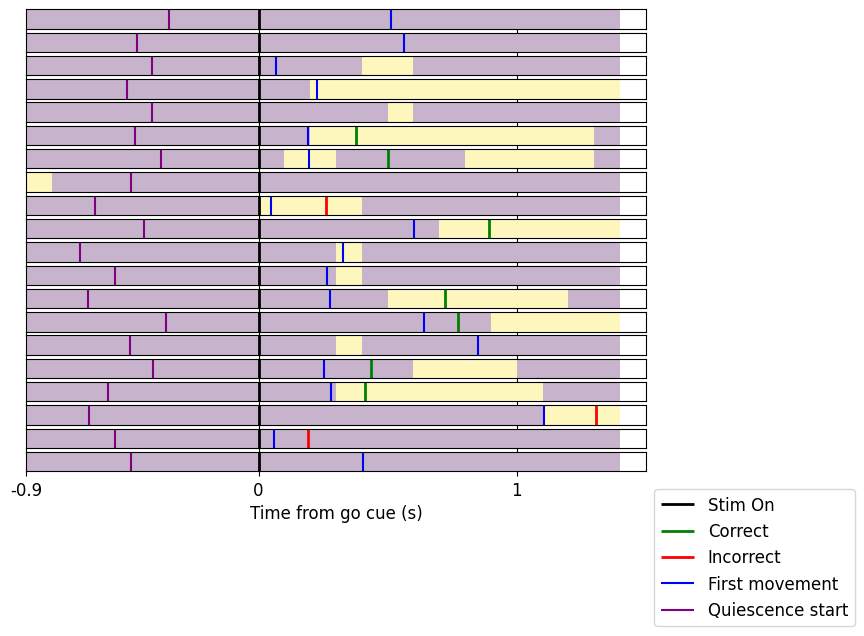

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


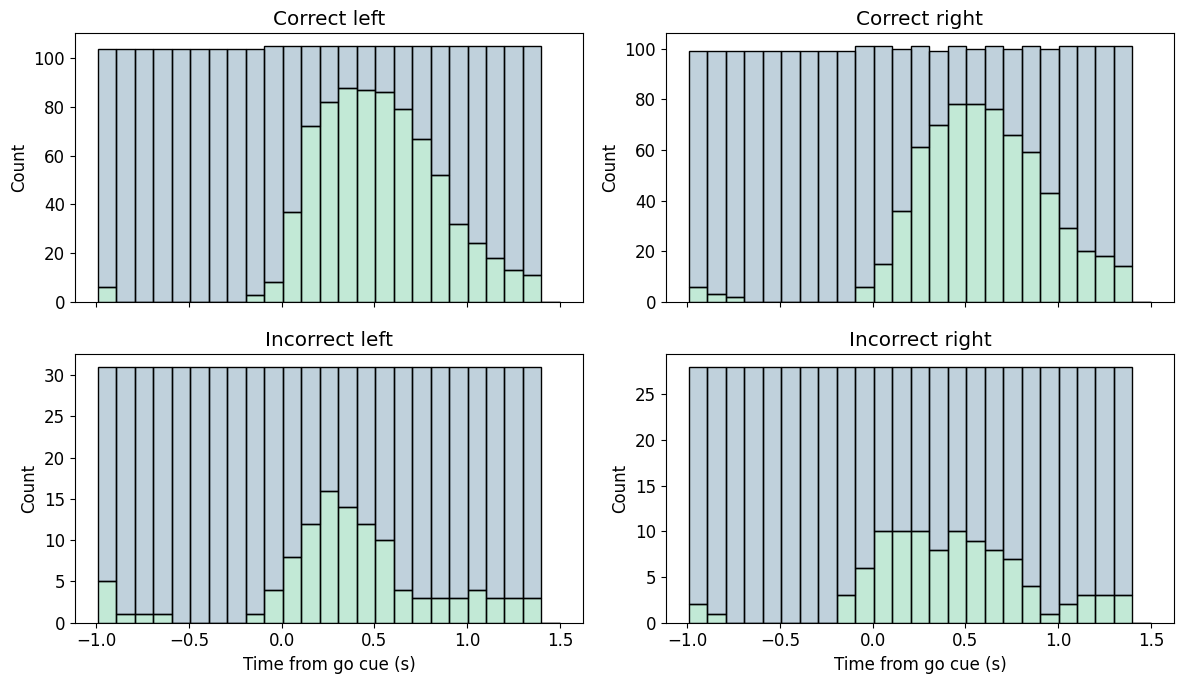

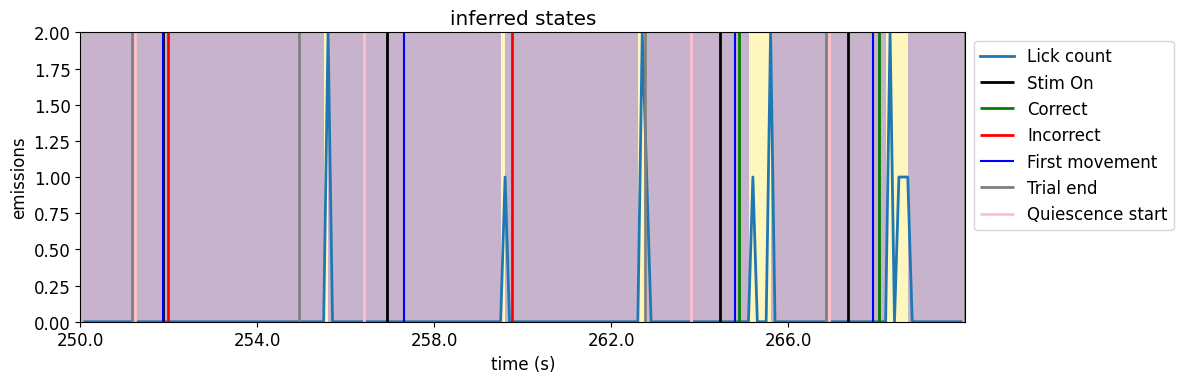

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


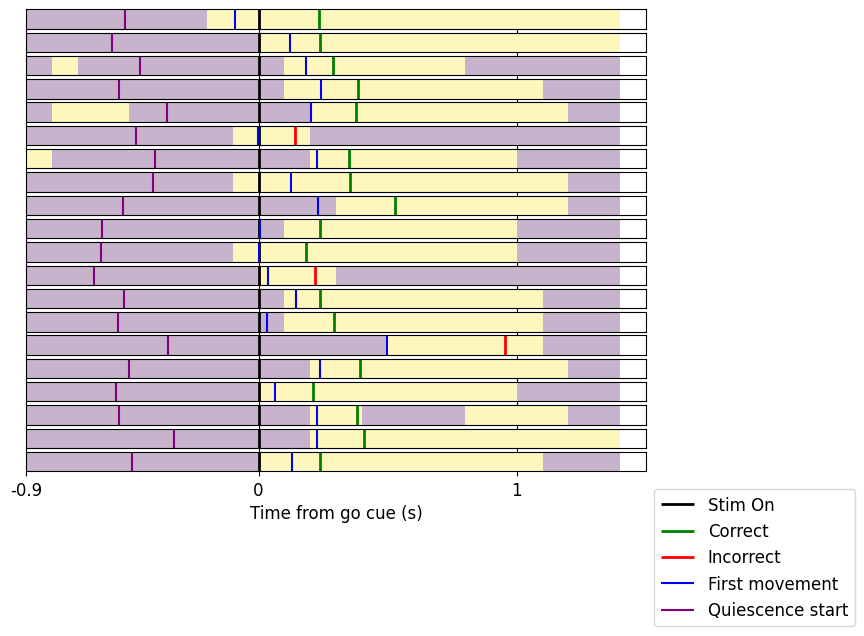

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


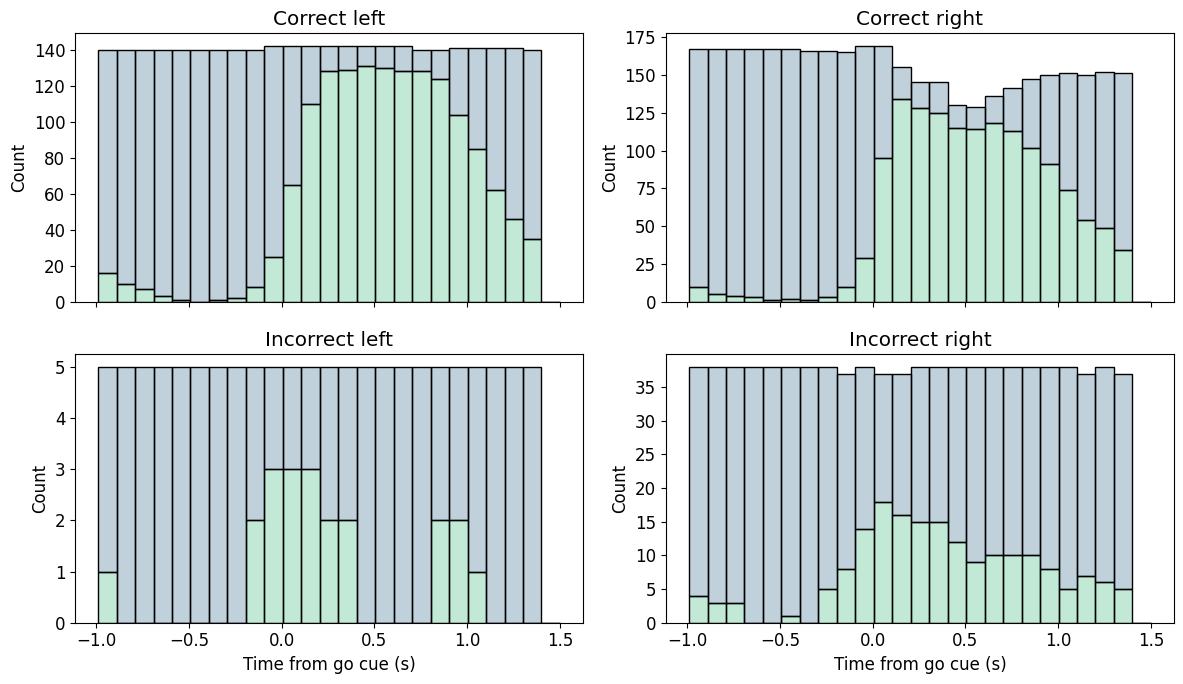

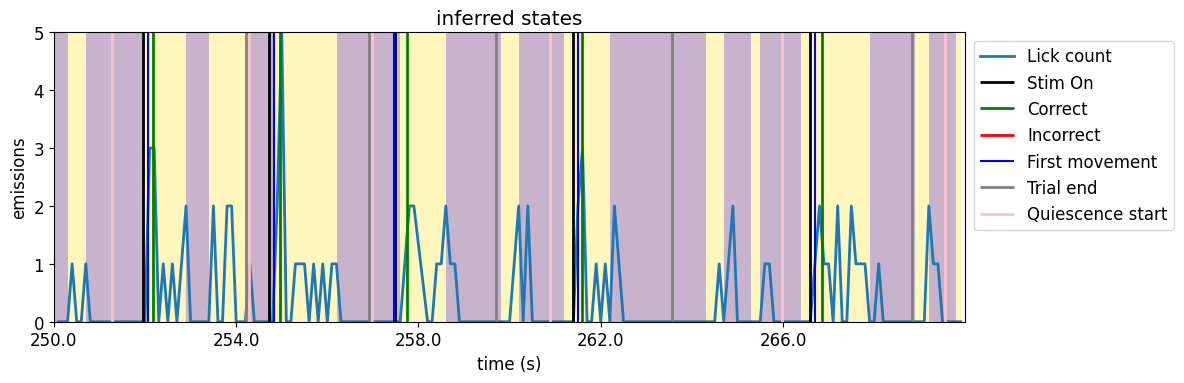

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


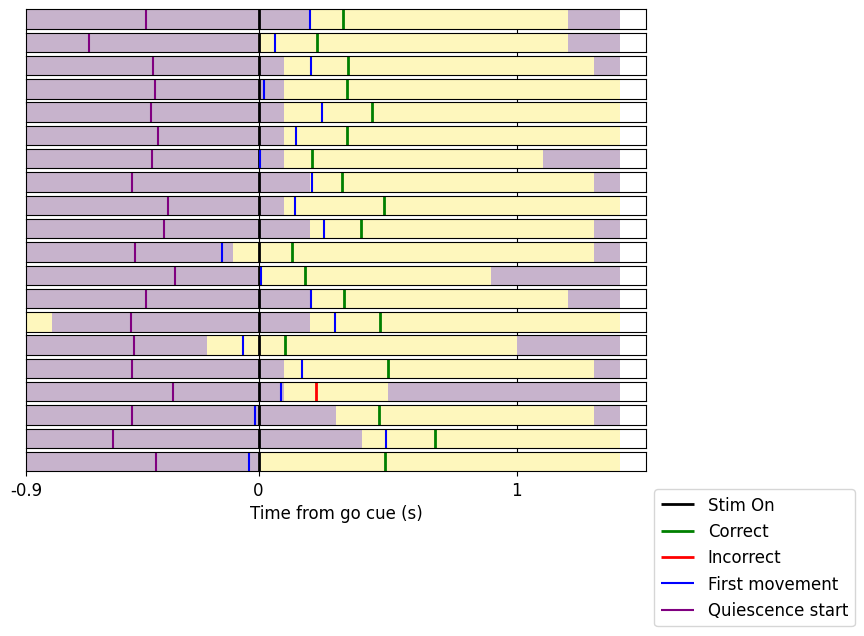

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


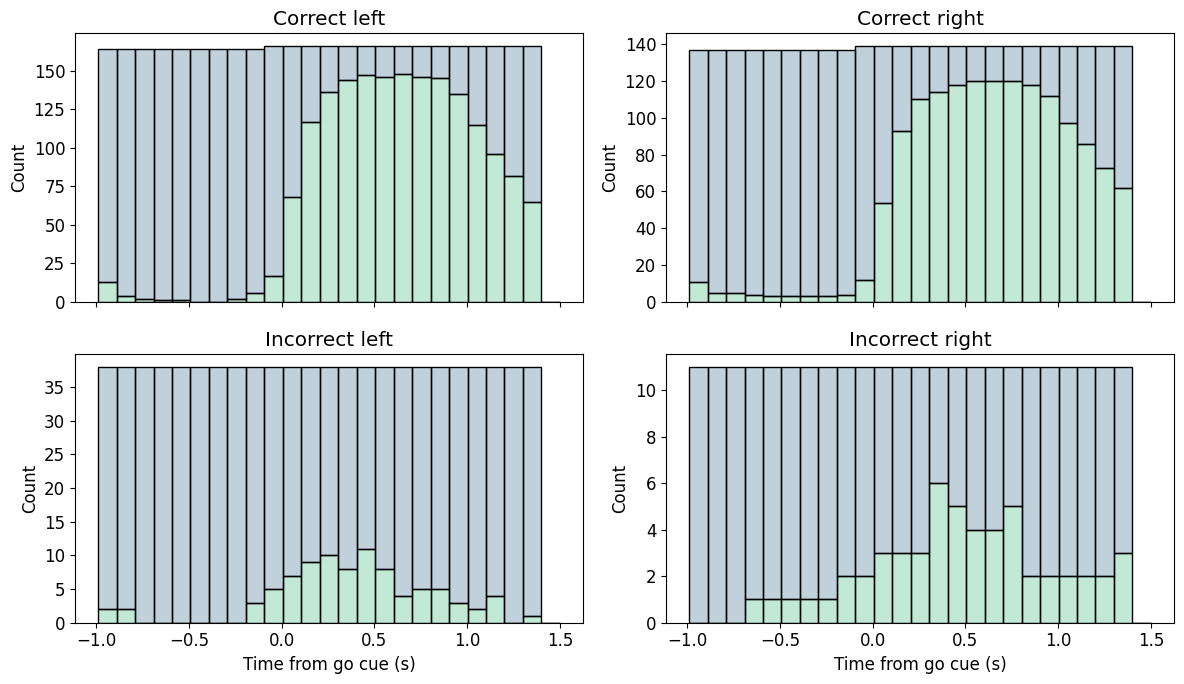

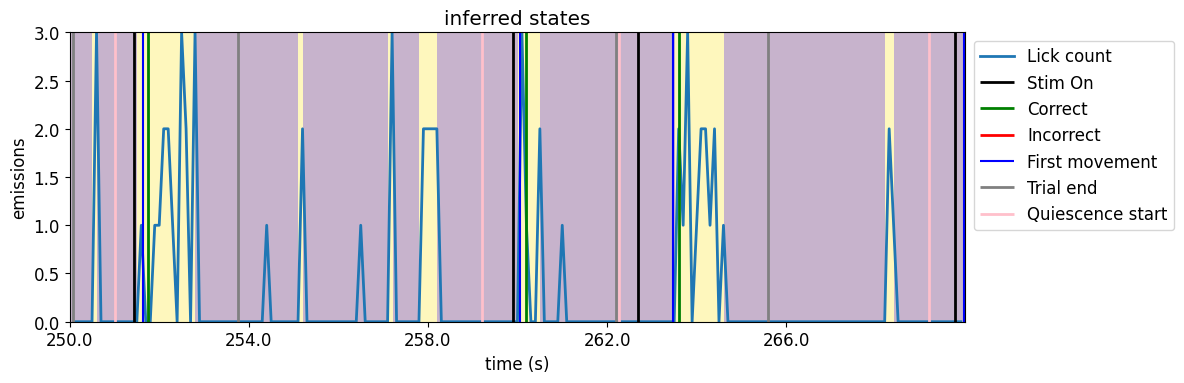

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

best_results_Lick count_DY_008not in folder
best_results_Lick count_DY_009not in folder
best_results_Lick count_DY_013not in folder
best_results_Lick count_DY_014not in folder
best_results_Lick count_DY_016not in folder
best_results_Lick count_DY_018not in folder


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


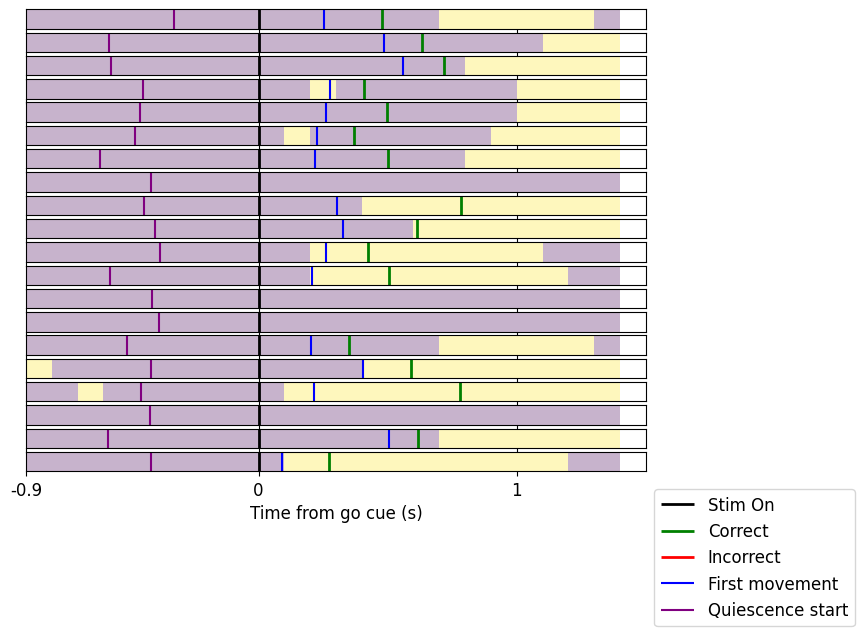

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


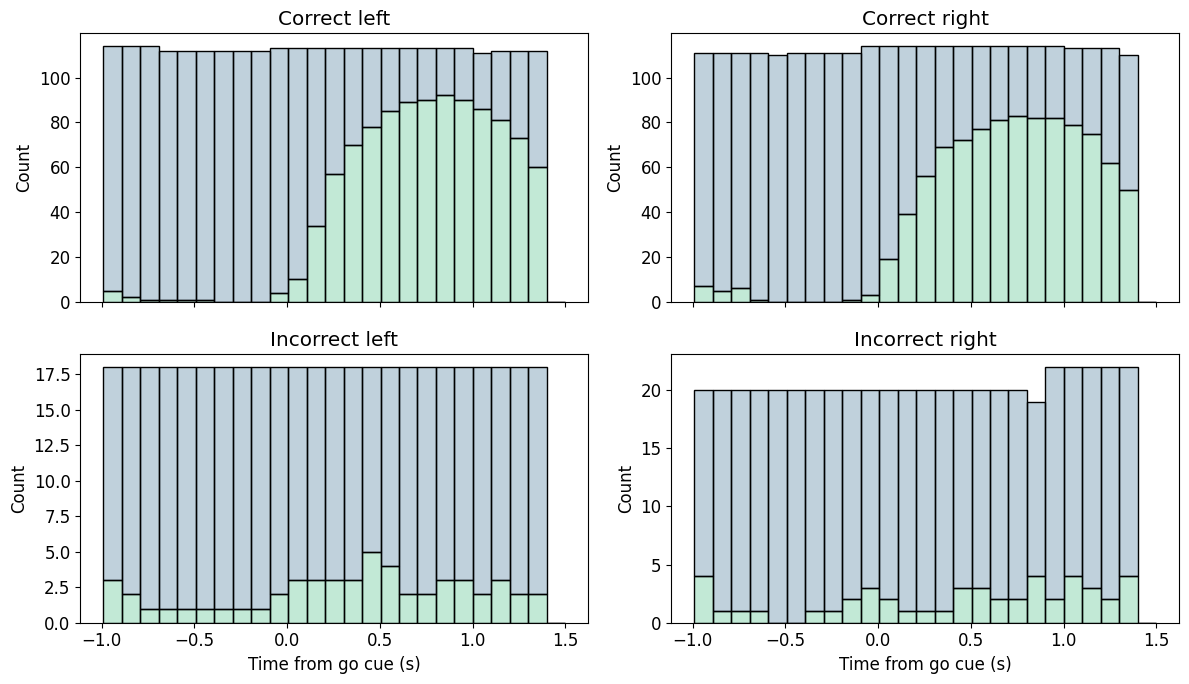

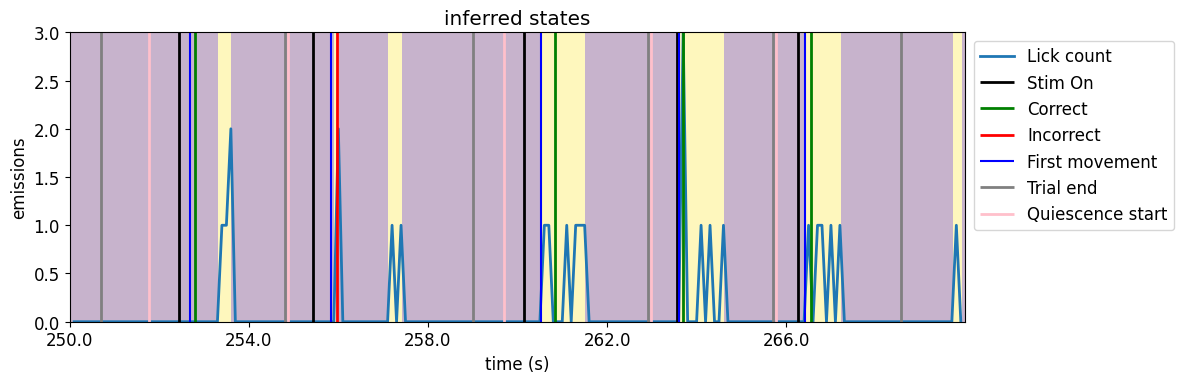

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

best_results_Lick count_KS022not in folder
best_results_Lick count_KS023not in folder
best_results_Lick count_KS044not in folder
best_results_Lick count_KS051not in folder
best_results_Lick count_KS084not in folder
best_results_Lick count_KS086not in folder
best_results_Lick count_KS091not in folder
best_results_Lick count_KS096not in folder
best_results_Lick count_NR_0020not in folder


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


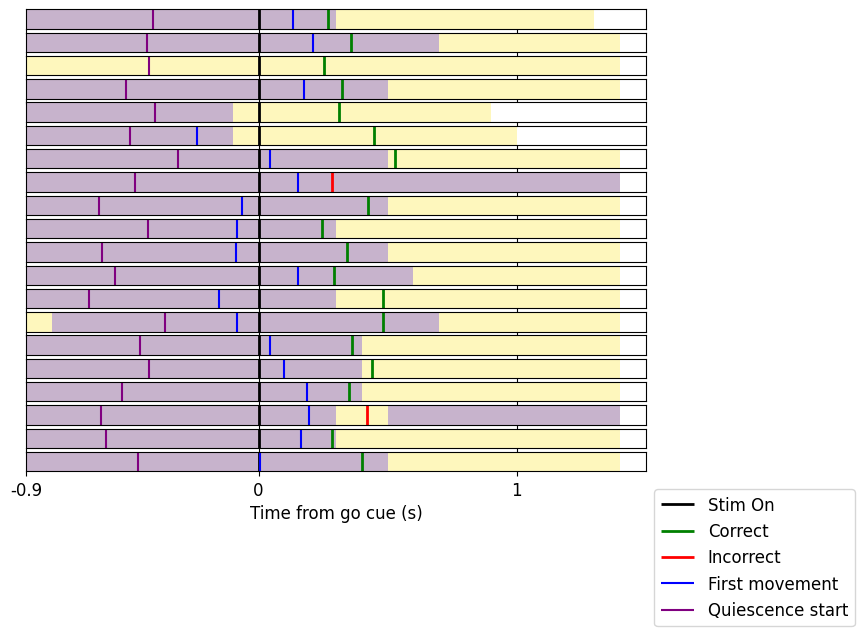

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


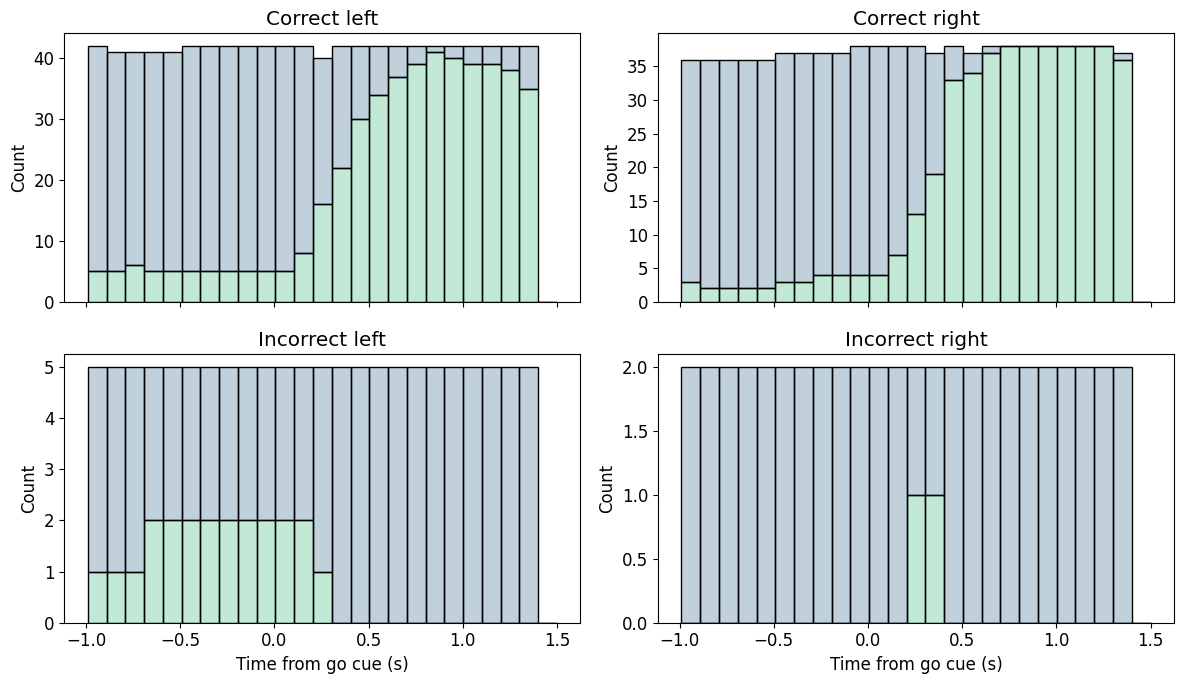

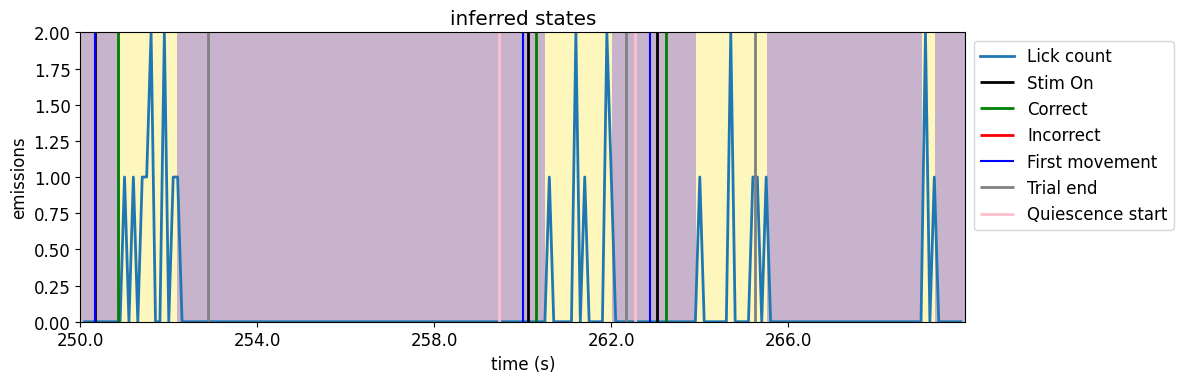

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

best_results_Lick count_PL015not in folder
best_results_Lick count_PL016not in folder
best_results_Lick count_PL017not in folder
best_results_Lick count_SWC_038not in folder
best_results_Lick count_SWC_043not in folder
best_results_Lick count_SWC_052not in folder
best_results_Lick count_SWC_053not in folder
best_results_Lick count_SWC_054not in folder
best_results_Lick count_SWC_058not in folder
best_results_Lick count_SWC_061not in folder
best_results_Lick count_SWC_065not in folder
best_results_Lick count_SWC_066not in folder


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


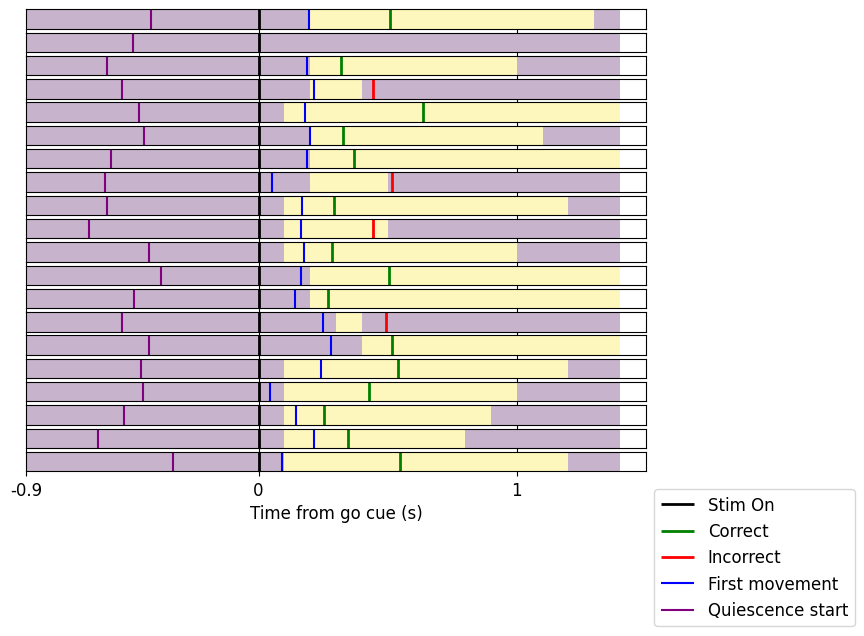

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


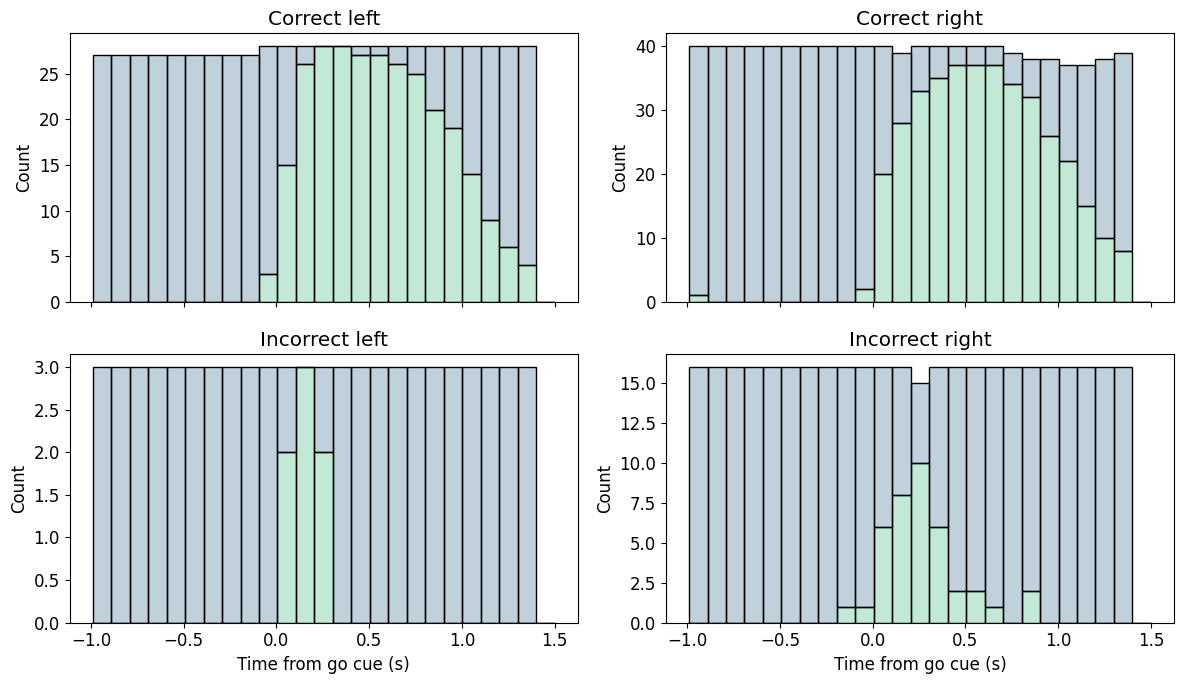

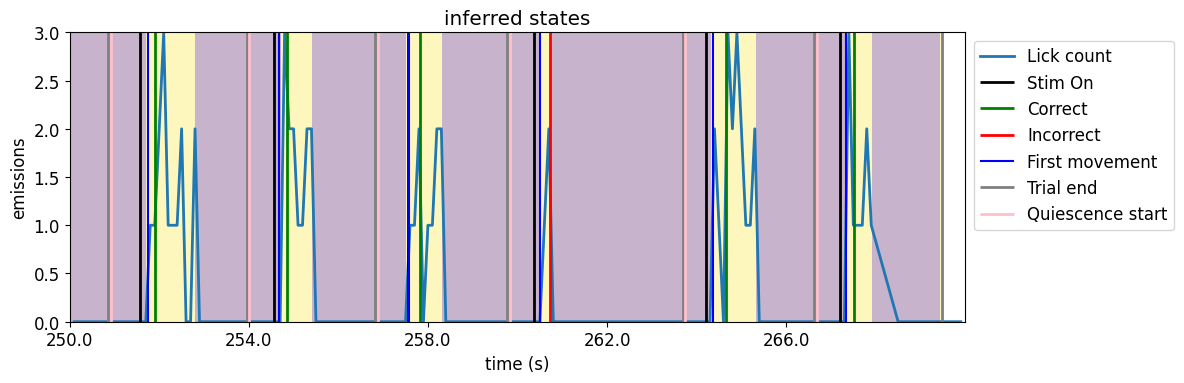

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


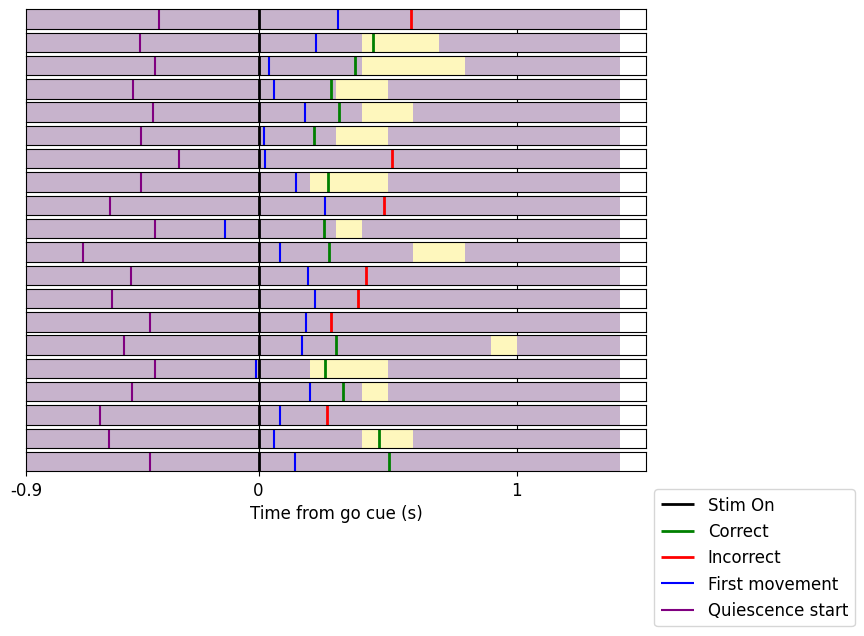

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


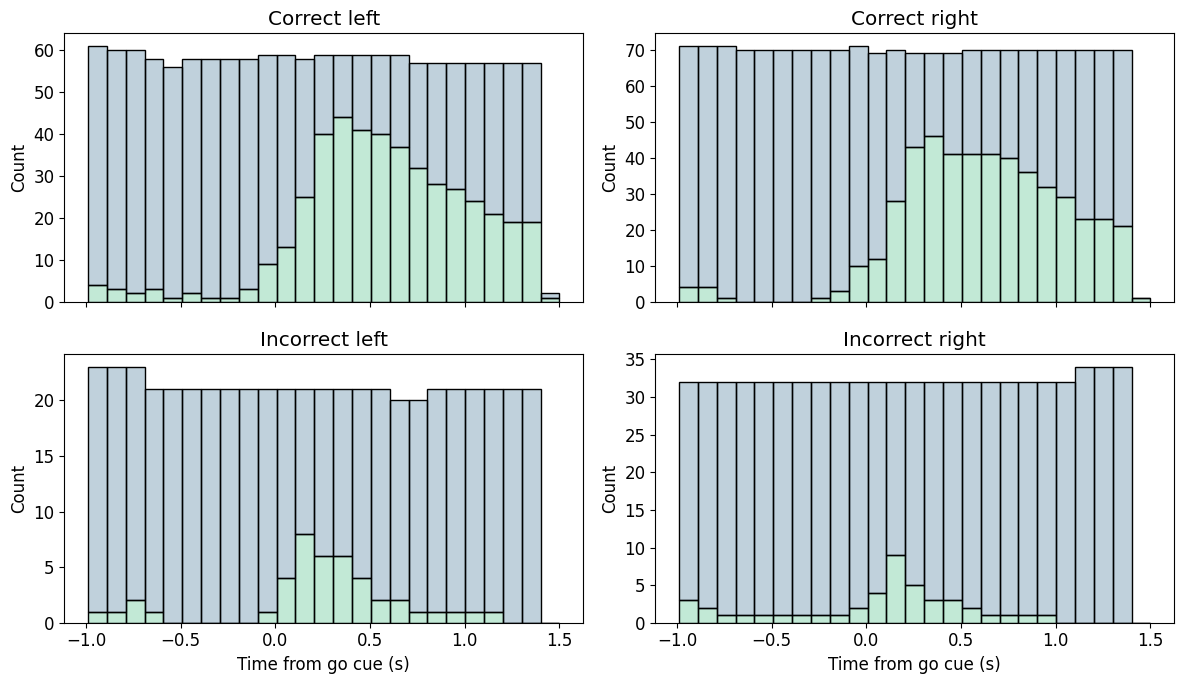

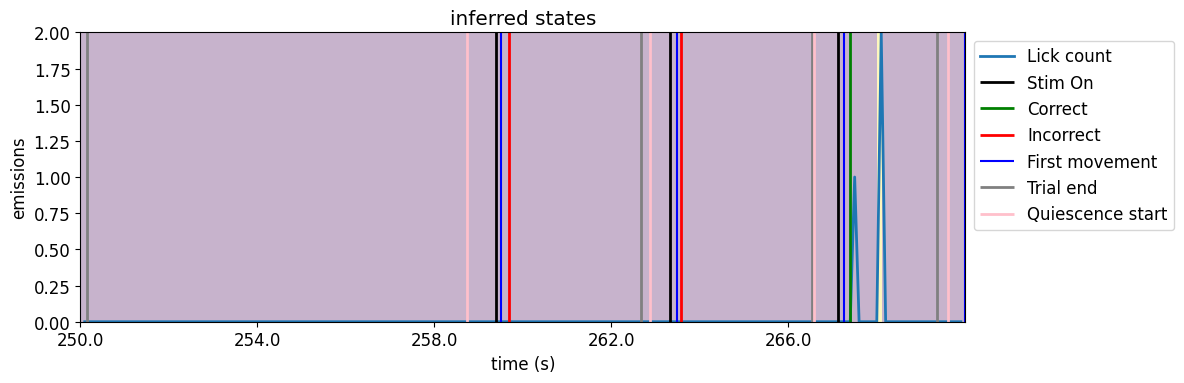

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


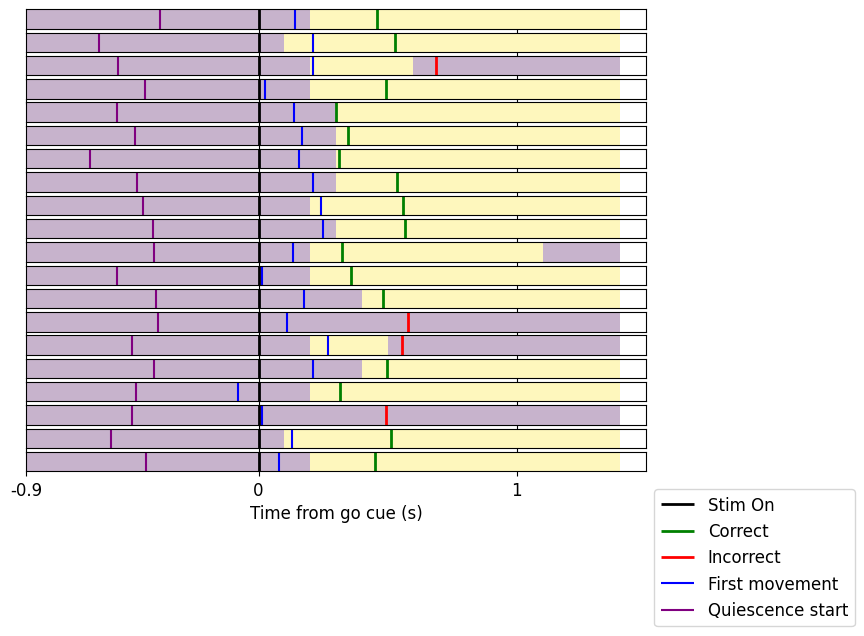

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


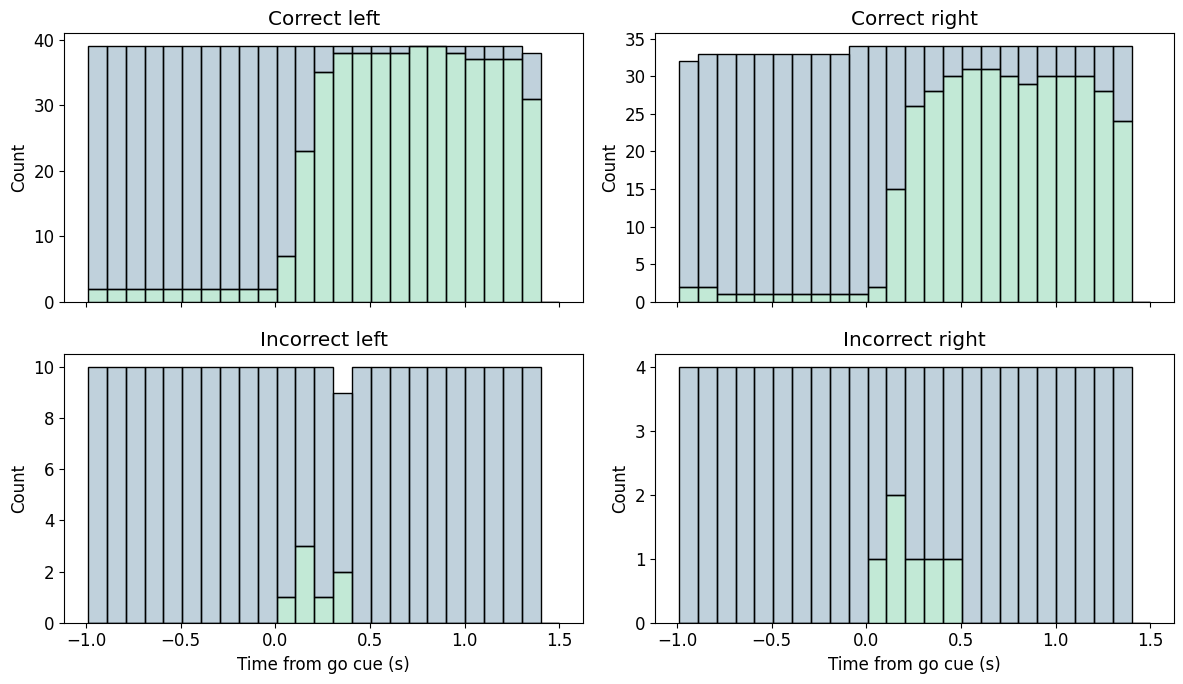

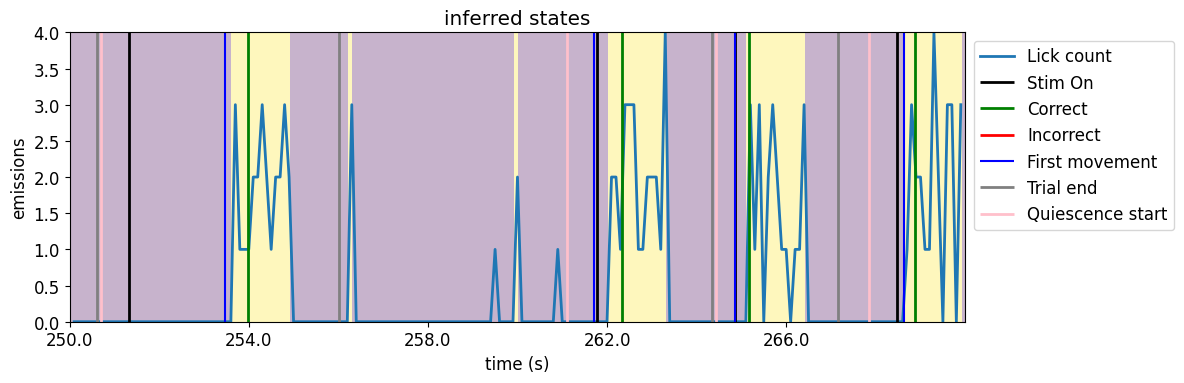

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


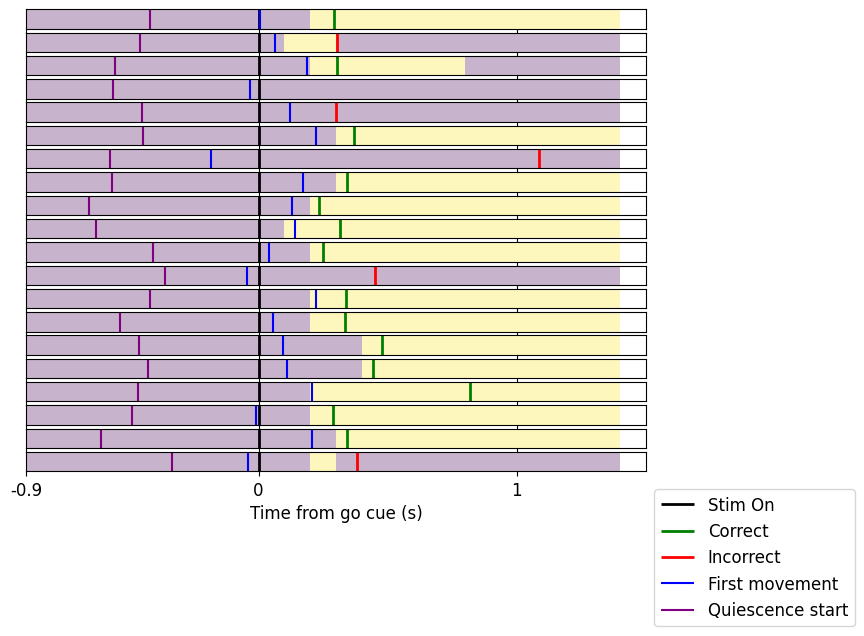

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


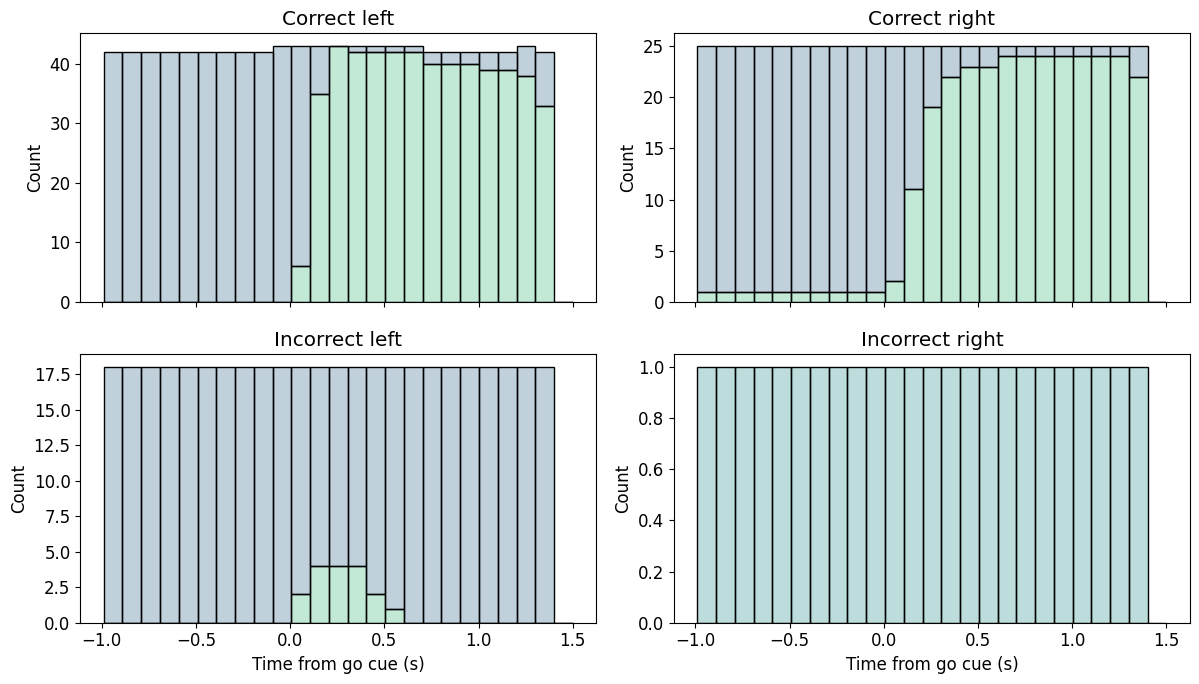

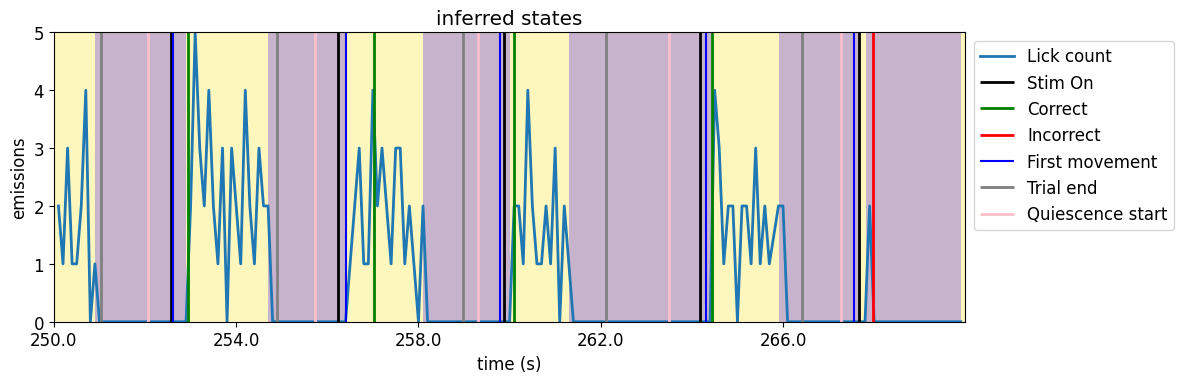

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


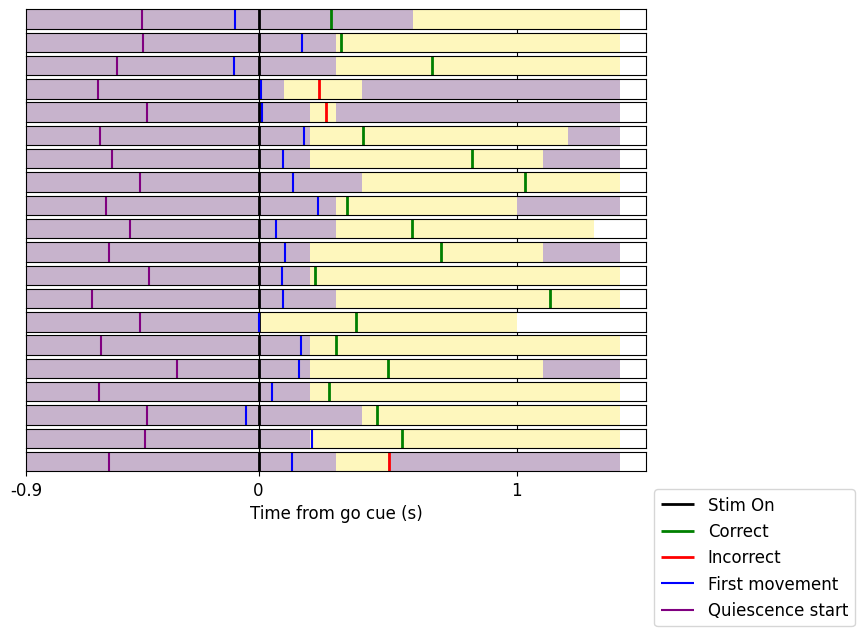

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


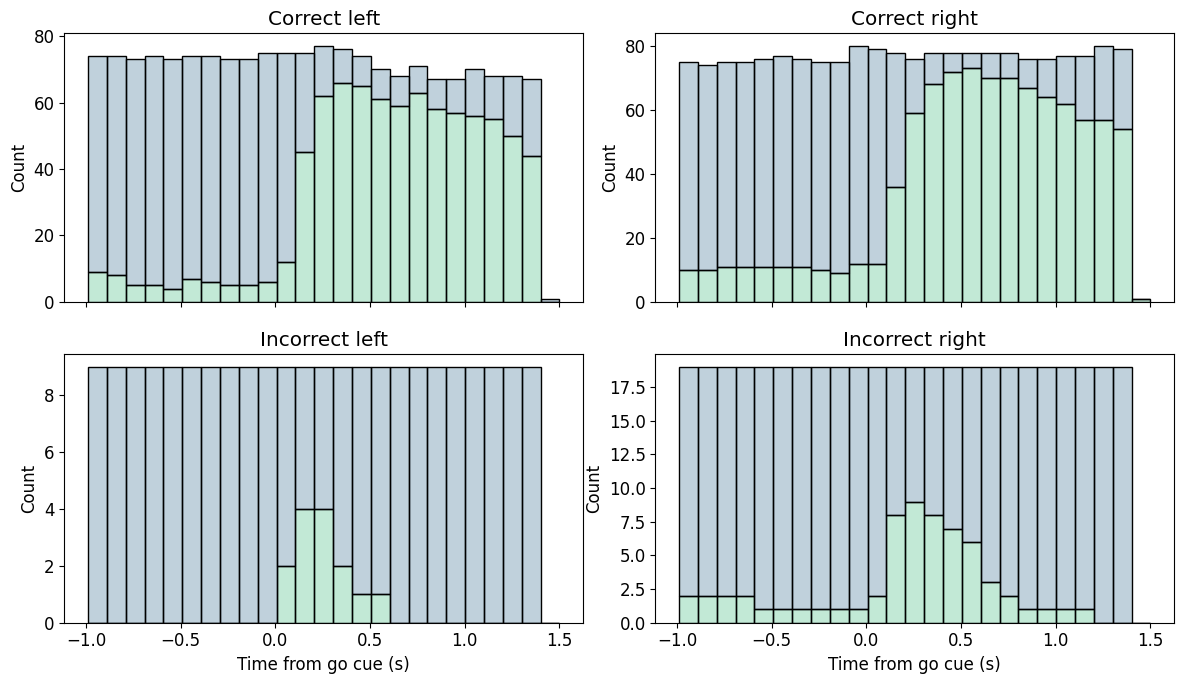

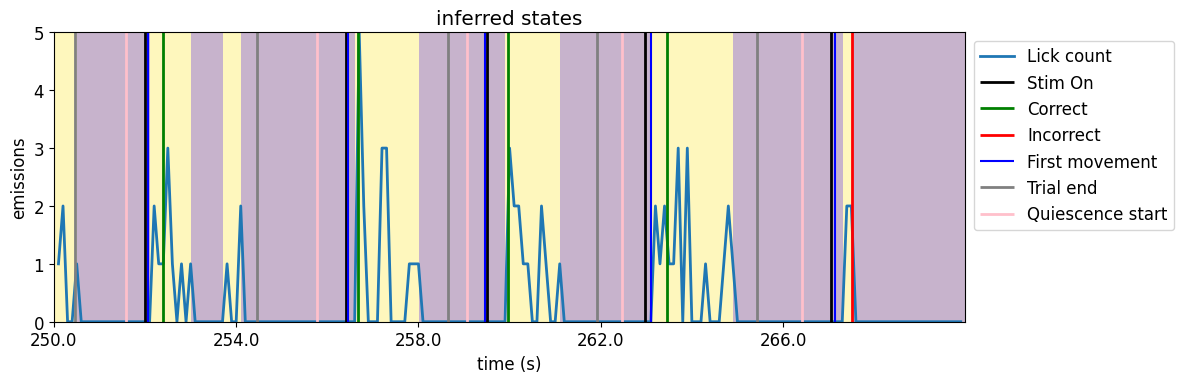

best_results_Lick count_ZFM-01592not in folder
best_results_Lick count_ZFM-01935not in folder
best_results_Lick count_ZFM-01936not in folder
best_results_Lick count_ZFM-02369not in folder
best_results_Lick count_ZFM-02370not in folder
best_results_Lick count_ZFM-02372not in folder
best_results_Lick count_ZFM-02373not in folder
best_results_Lick count_ZM_1898not in folder
best_results_Lick count_ZM_2240not in folder
best_results_Lick count_ZM_2241not in folder
best_results_Lick count_ZM_2245not in folder
best_results_Lick count_ZM_3003not in folder
best_results_Lick count_ibl_witten_25not in folder
best_results_Lick count_ibl_witten_26not in folder
best_results_Lick count_ibl_witten_29not in folder


/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [22]:
for m, mouse_name in enumerate(np.unique(mouse_names)):

    index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
    idx_init = idx_init_list[index_var]
    idx_end = idx_end_list[index_var]
    var_names = use_sets[index_var]
    
    # Get mouse data
    session_trials = collapsed_trials[mouse_name]
    design_matrix = collapsed_matrices[mouse_name][:,idx_init:idx_end]
    unnorm_mat = collapsed_unnorm[mouse_name][var_names]
    unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
    
    # Get results from grid search
    results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/grid_search'
    os.chdir(results_path)
    files = os.listdir()
    if sticky == True:
        filename = "best_sticky_results_" + var_names[0] + '_' + mouse_name
    else:
        filename = "best_results_" + var_names[0] + '_' + mouse_name
    
    if filename in files:
        try:
            all_lls, all_baseline_lls, all_init_params, all_fit_params = pickle.load(open(filename, "rb"))

            # Prepare data format
            num_timesteps = np.shape(design_matrix)[0]
            emission_dim = np.shape(design_matrix)[1]
            shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
            train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
            
            # Get best params and fold
            best_kappa, mean_bits_LL, best_fold = best__kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas)
            index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
            use_fold = int(best_fold[index_kappa])

            " Fit model with best params"
            best_params = all_fit_params[best_kappa]
            
            # Find parameters for best fold
            initial_probs = best_params[0].probs[use_fold]
            transition_matrix = best_params[1].transition_matrix[use_fold]
            emission_rates = best_params[2].rates[use_fold]        

            # Initialize new hmm
            new_bhmm = PoissonHMM(num_states, emission_dim)
            best_fold_params, props = new_bhmm.initialize(key=jr.PRNGKey(0), method=method,
                                            initial_probs=initial_probs,
                                            transition_matrix=transition_matrix,               
                                            emission_rates=emission_rates) 
            
            # Get state estimates for validation data
            most_likely_states = new_bhmm.most_likely_states(best_fold_params, shortened_array)


            # Keep only enough states to explain 95% observations
            unique, counts = np.unique(most_likely_states, return_counts=True)
            threshold_count = threshold * len(most_likely_states)
            excluded_bins = 0
            remaining_states = list(counts.copy())
            for state in unique:
                size_smallest_state = np.nanmin(remaining_states)
                if size_smallest_state + excluded_bins < threshold_count:
                    remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                    excluded_bins += size_smallest_state
            
            # Remove states below threshold
            new_states = np.array(most_likely_states).astype(float)
            exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
            # Create a boolean mask to identify values to replace
            mask = np.isin(new_states, exclude_states)
            # Replace values in main_array with np.nan using the boolean mask
            new_states[mask] = np.nan

            new_states = most_likely_states
            
            " Plots "
            # Prepare data
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
            bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
            design_matrix_heading['Bin'] = bins
            
            # Fix discontinuities
            cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)
            
            # Align bins
            init = -1 * multiplier
            end = 1.5 * multiplier
            empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)


            """ Stack trial states """
            trial_init = 30  # First trial to plot
            trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
            plot_states_aligned_trial(trial_init, empirical_data, cont_trials, bin_size, trials_to_plot, num_states)

            " Plot states stacked and aligned per trial type "
            plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
            
            # """ Plot states per trial epoch """
            # colors = sns.color_palette("viridis", num_states)
            # # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            # states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)
            # sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
            #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)
            # plt.figure(figsize=[7, 5])
            # plt.xticks(rotation=45)
            # plt.tight_layout()
            # plt.title(mouse_name)
            # plt.show()

            """ Plot raw traces over states """
            init = 250*multiplier # First bin
            inter = 20*multiplier
            # traces_over_few_sates(init, empirical_data, session_trials, var_names)
            traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier)
        except:
            print(mouse_name)
    else:
        print(filename + 'not in folder')